### Initialize

In [6]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import scipy.optimize
import scipy.special
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import ipywidgets

cst = tp.cst(sigmaf=0.5, trapw = 2*np.pi*23.35)
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done


In [7]:
# Bunch of functions 

def lorentian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
        print(df.head(2))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

In [8]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.35,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.1, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [9]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.35):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

Basic Setup

In [10]:
# # Initialize Dataframe 
# df = get_from_clipboard(init=True)
# var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime']
# x_var = 'WaitBox'

# # Import from Clipboard
# df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Image, using=0)

# # Define Settings 
# settings = {**default_settings, 
#             **dict(center_x = 1032, center_y = 1224, width=1000, height=1000, fudge=1.82)}

# # Apply settings
# for i, r in df.iterrows():
#     r.image.set(**settings)

# # Tests
# test = 20
# print(df.image.iloc[test].name)
# df.image.iloc[test].plot_crop()
# print(df.x.iloc[test])

# # Atom number
# df['total_atoms'] = [im.total_atoms for im in tqdm(df.image)]
# nums = df['total_atoms'].values
# plt.plot(nums)

# # roi
# width, height = 50, 50
# center = [df.image.iloc[0].app.shape[1] // 2, df.image.iloc[0].app.shape[0] // 2]
# center = np.array(center) + np.array([0, 0])
# roi = [slice(center[1] - height, center[1] + height + 1), slice(center[0] - width, center[0] + width + 1)]
# plt.imshow(df.image.iloc[0].app[roi])

# Imaging Resonances

## Side - Low Magnification - Ultra Low Intensity


============== LOADING IMAGES ==============

Total Images 23

============== Testing Crop Settings ==============
07-25-2017_15_20_38
155.5


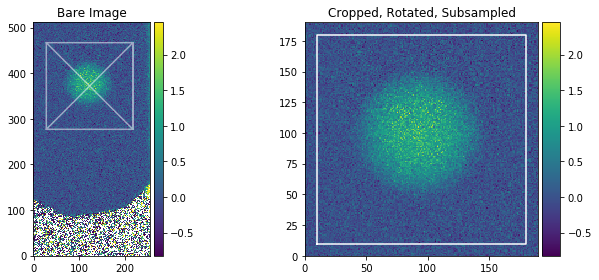


============== Testing Region Of Interest ==============


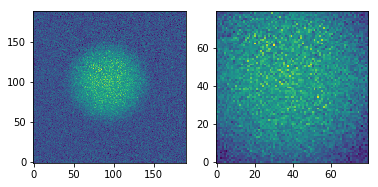


============== Fitting ==============
WARNING! Background correction is larger than 10%. Imagename 07-25-2017_15_23_36
##______Fit Value______Error______
 0 ==>     155.8 (+-)   0.04644
 1 ==>     3.028 (+-)    0.1972
 2 ==>     1.026 (+-)   0.03424
 3 ==>   0.02081 (+-)   0.02188


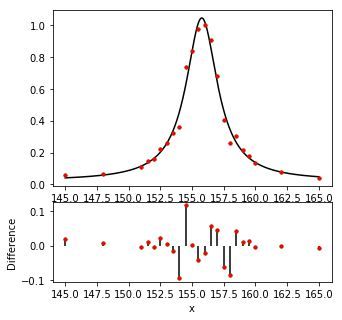


============== Bootstrapping ==============


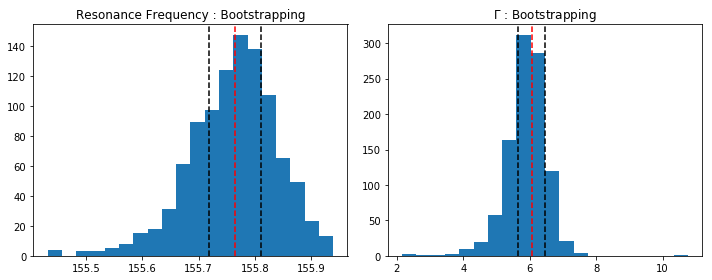


============== Main Plot ==============
S1 : 155.76 +- 0.05
S2 : 194.39
S3 : 236.43


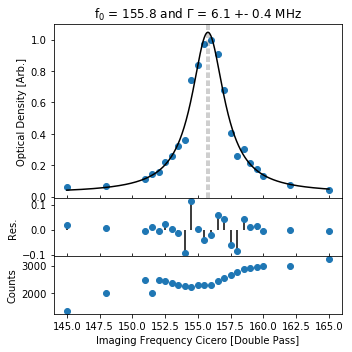

In [11]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['ImagFreq0','ImagFreq1','ImagFreq2','ImgPower1','ImgPower2']
x_var = 'ImagFreq0'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

# If ImagFreq0 is no good, use ImagFreq1
# x_var = 'ImagFreq1'
# df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)

print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 123, center_y = 372, width=190, height=190, 
                   subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 80, 80
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[1], df.image.iloc[test].od.shape[0]//2 + center_offset[0]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Fitting
print("\n============== Fitting ==============")
def imsum(od):
    od = od[roi]
    od = od[np.abs(od) < 10000]
    return np.nansum(od)
df['total_atoms'] = np.array([imsum(im.od) for im in df.image])
c = tp.Curve(x = np.array(df.x), y = np.array(df.total_atoms))
c.removenan() 
res_curve = tp.Curve(x = c.x, y = c.y/c.y.max()).sortbyx() 
guess = [res_curve.x.mean(), 3, 1, 0] 
fitres, fiterr = res_curve.fit(lorentian_fitfun, guess, 
                       plot=True)
plt.show()


# Bootstrapping 
print("\n============== Bootstrapping ==============")
runs = 1000
frs = []

for i in range(runs):
    usei = np.arange(res_curve.x.size)
    usei = np.random.choice(usei, usei.size)
    c_temp = tp.Curve(x = res_curve.x[usei], y = res_curve.y[usei])
    frs.append(c_temp.fit(lorentian_fitfun, guess, plot=False)[0])
frs = np.array(frs)

# plots
fig, ax = plt.subplots(figsize=[10,4], ncols=2)
ax[0].hist(frs[:, 0],20)
ax[0].axvline(fitres[0], color='red', linestyle='--')
ax[0].axvline(fitres[0]-fiterr[0], color='black', linestyle='--')
ax[0].axvline(fitres[0]+fiterr[0], color='black', linestyle='--')
ax[0].set(title='Resonance Frequency : Bootstrapping')
ax[1].hist(frs[:, 1]*2,20)
ax[1].axvline(fitres[1]*2, color='red', linestyle='--')
ax[1].axvline(fitres[1]*2-fiterr[1]*2, color='black', linestyle='--')
ax[1].axvline(fitres[1]*2+fiterr[1]*2, color='black', linestyle='--')
ax[1].set(title=r'$\Gamma$ : Bootstrapping')
fig.tight_layout() 
plt.show()


# Plot 
print("\n============== Main Plot ==============")
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot2grid((5,1), (0,0), rowspan=3)
ax2 = plt.subplot2grid((5,1), (3,0), sharex=ax1)
ax3 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax1.get_xaxis().set_tick_params(direction='in')
ax2.get_xaxis().set_tick_params(direction='in')

ax1.plot(*res_curve.plotdata,'o')
ax1.plot(*res_curve.xyfitplot,'k-')
# ax1.axvline(fitres[0], c='k', linestyle='--', alpha=0.5)
ax1.axvline(fitres[0] + fiterr[0], c='k', linestyle='--', alpha=0.25)
ax1.axvline(fitres[0] - fiterr[0], c='k', linestyle='--', alpha=0.25)
ax2.plot(res_curve.x, res_curve.y - res_curve.yfit,'o')
ax2.vlines(res_curve.x, res_curve.x*0, res_curve.y - res_curve.yfit)
ax3.plot(df.x, [im.Ii_avg for im in df.image],'o')

ax1.set(ylabel='Optical Density [Arb.]', title=r'f$_0$ = {:.1f} and $\Gamma$ = {:.1f} +- {:.1f} MHz'.format(fitres[0], fitres[1]*2, fiterr[1]*2))
ax2.set(ylabel='Res.')
ax3.set(xlabel='Imaging Frequency Cicero [Double Pass]', ylabel='Counts')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

print('''S1 : {:.2f} +- {:.2f}
S2 : {:.2f}
S3 : {:.2f}'''.format(fitres[0], fiterr[0], fitres[0] + 38.63, fitres[0] + 80.67))


## Side - High Magnification

## Top - Double Imaging

## Top - Single Imaging

# RF Spectroscopy

## Theory - Polarized

In [ ]:
@np.vectorize
def rabi_oscillation(tau=0, fR=3e3, delta=0, f=None, f0=None):
    if (f0 is not None) and (f is not None): delta = f0-f
    elif f0 is not None: delta=0.0
    elif f is not None: delta=0.0
    return fR**2 / (fR**2 + delta**2) * np.sin(np.pi * tau * (fR**2 + delta**2)**(1/2))**2

In [ ]:
# vs. detuning plots
def vs_detuning(delta=1.0, fR=0.5, tau=1.0, points=15):
    delta = np.linspace(-delta, delta, points) * 1e3
    tsf = rabi_oscillation(tau = tau * 1e-3, fR = fR * 1e3, delta = delta)
    plt.plot(delta / 1e3, tsf, 'o-')
    plt.xlabel('Detuning [kHz]')
    plt.ylabel('Transfer Fraction')
    plt.title("Rabi Resonance; spacing {:.3f} kHz".format((delta[1]-delta[0])/1e3 ))
ipywidgets.interact(vs_detuning, delta = (0.1, 2, 0.05), fR = (0.1, 3, 0.05), tau = (0.2, 3, 0.05), points = (1, 30, 1))

In [ ]:
rabi2volt(0.5)

## vs. Detuning - Polarized

In [ ]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
var = ['RFspect','PulseTime','SpectVolt']
x_var = 'RFspect'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)
print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1130, center_y = 1300, width=800, height=1500, )}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 100, 300
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Atom num selection
print("\n============== Atom Nums ==============")
keep = 0.20
offset = 1 + 0.0
df['total_atoms'] = np.array([np.nansum(im.app[roi]) for im in tqdm(df.image, desc='Atoms')])
x = df.shot[::2].values
nA = df.total_atoms[::2].values
nB = df.total_atoms[1::2].values
nTotal = nA + nB
median_numbers = np.median(nTotal)
using = (nTotal >= median_numbers * (offset - keep)) & (nTotal <= median_numbers * (offset + keep))
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(x, nTotal/1e6, '.-', label='all')
ax[0].plot(x[~using], nTotal[~using]/1e6, 'rx', label='Removed Shots')
ax[1].plot(x[using], nTotal[using] / median_numbers, 'o-')
ax[0].legend()
plt.show()

rabi_osc = tp.Curve(df.x[::2].values[using]*1e6, nB[using] / nTotal[using]).sortbyx()


# Fit
print("\n============== Fitting ==============")
tau = 1e-3
def fitfun(w, w0, wR, offset=0):
    amp = (wR**2)/(wR**2 + (w-w0)**2) 
    phase = np.pi*tau*np.sqrt(wR**2+(w0-w)**2)
    return amp * (np.sin(phase))**2 + offset
guess = [76.0327e6, 0.5e3, 0]
fitres, fiterr = rabi_osc.fit(fitfun, guess, plot=True)
plt.show()

# Plots 
plt.plot((rabi_osc.x - fitres[0])/1e3, rabi_osc.y,'.')
plt.plot((rabi_osc.xyfitplot[0] - fitres[0])/1e3, rabi_osc.xyfitplot[1],'--')
plt.xlabel('Detuning [kHz]')
plt.ylabel('Transfer')
plt.legend(['Data','Fit'])
plt.title('$f_0$ {:.4f} MHz  and  $f_R$ {:.3f} $\pm$ {:.3f} kHz'.format(fitres[0]/1e6, fitres[1]/1e3, fiterr[1]/1e3))
plt.tight_layout()
plt.show()

# Bootstrapping 
runs = 1000
f0s = []

for i in range(runs):
    usei = np.arange(rabi_osc.x.size)
    usei = np.random.choice(usei, usei.size)
    c_temp = tp.Curve(x = rabi_osc.x[usei], y = rabi_osc.y[usei])
    f0s.append(c_temp.fit(fitfun, fitres, plot=False)[0][0] / 1e6)
f0s = np.array(f0s)
subtract = 76.032
# plots
fig, ax = plt.subplots(figsize=[6,4])
ax.hist((f0s-subtract)*1000,40)
ax.axvline((fitres[0]/1e6-subtract)*1000, color='red', linestyle='--')
ax.axvline(((fitres[0]-fiterr[0])/1e6-subtract)*1000, color='black', linestyle='--')
ax.axvline(((fitres[0]+fiterr[0])/1e6-subtract)*1000, color='black', linestyle='--')
ax.set(title='Bootstrapping : f0 : {:.5f} +- {:.5f} MHz'.format(fitres[0]/1e6, fiterr[0]/1e6))
ax.set(xlabel='(f0 - {})*1000'.format(subtract), ylabel='Histogram')
fig.tight_layout()
plt.show()

## vs. Pulse Time - Polarized

## vs. Rabi Frequency - Polarized

## Box Contact - Double Imaging

In [ ]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'PulseTime', 'RFspect', 'Spect Volt', ]
x_var = 'PulseTime'
df_all = get_from_clipboard(x_var = x_var, image_func=tp.Image, var=var, using=2, display=False)

# Crop images
settingsA = {**default_settings, 
             **dict(center_x = 1152, center_y = 1270, width = 600, height = 600, fudge = 1)}
settingsB = {**settingsA, **dict(width = 1200, height = 1200)}

for i, r in df_all[0::2].iterrows(): r.image.set(**settingsA)
for i, r in df_all[1::2].iterrows(): r.image.set(**settingsB)

# Test
test = 4*2
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df_all.image.iloc[test+0].plot_crop(ax=ax[0:2])
df_all.image.iloc[test+1].plot_crop(ax=ax[2:4])

plt.tight_layout()
plt.show()

In [ ]:
# Atom Number fluctuations 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
using = atom_num_filter(df_all.iloc[1::2], keep=0.10, offset=0.0)
using = np.array([using, using]).T.flatten()
df = df_all[using]

In [ ]:
# Define ROI and test  
avg_od_A = np.nanmean([im.od for im in df.image[0::2]], axis=0)
avg_od_B = np.nanmean([im.od for im in df.image[1::2]], axis=0)
roiA = get_roi(avg_od_A, center=[-4, 3], width=65, height=60)
roiB = get_roi(avg_od_B, center=[0, 0], width=250, height=230)

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=[14,6])
ax = ax.flatten()

clim = [-0.05,0.2]
w = 10
s = avg_od_A.shape
ax[0].imshow(avg_od_A, clim=clim, origin='lower')
ax[0].axvline(roiA[1].start, color='w', linestyle='--',alpha=0.7)
ax[0].axvline(roiA[1].stop-1, color='w', linestyle='--',alpha=0.7)
ax[0].axhline(roiA[0].start, color='w', linestyle='--',alpha=0.7)
ax[0].axhline(roiA[0].stop-1, color='w', linestyle='--',alpha=0.7)
ax[1].imshow(avg_od_A[roiA], clim=clim, origin='lower')
ax[2].plot(np.nansum(avg_od_A[s[0]//2-w:s[0]//2+w, :], axis=0))
ax[2].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[2].axvline(roiA[1].start, color='k', linestyle='--',alpha=0.5)
ax[2].axvline(roiA[1].stop-1, color='k', linestyle='--',alpha=0.5)
ax[3].plot(np.nansum(avg_od_A[:,s[1]//2-w:s[1]//2+w], axis=1))
ax[3].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[3].axvline(roiA[0].start, color='k', linestyle='--',alpha=0.5)
ax[3].axvline(roiA[0].stop-1, color='k', linestyle='--',alpha=0.5)

clim = [-0.1,0.1]
w = 10
s = avg_od_B.shape
ax[4].imshow(avg_od_B, clim=clim, origin='lower')
ax[4].set(xlabel='x', ylabel='y')
ax[4].axvline(roiB[1].start, color='w', linestyle='--',alpha=0.7)
ax[4].axvline(roiB[1].stop-1, color='w', linestyle='--',alpha=0.7)
ax[4].axhline(roiB[0].start, color='w', linestyle='--',alpha=0.7)
ax[4].axhline(roiB[0].stop-1, color='w', linestyle='--',alpha=0.7)
ax[5].imshow(avg_od_B[roiB], clim=clim, origin='lower')
ax[5].set(xlabel='x', ylabel='y')
ax[6].plot(np.nansum(avg_od_B[s[0]//2-w:s[0]//2+w, :], axis=0))
ax[6].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[6].set(xlabel='x')
ax[6].axvline(roiB[1].start, color='k', linestyle='--',alpha=0.5)
ax[6].axvline(roiB[1].stop-1, color='k', linestyle='--',alpha=0.5)
ax[7].plot(np.nansum(avg_od_B[:,s[1]//2-w:s[1]//2+w], axis=1))
ax[7].axhline(0, color='k', linestyle='--',alpha=0.5)
ax[7].set(xlabel='y')
ax[7].axvline(roiB[0].start, color='k', linestyle='--',alpha=0.5)
ax[7].axvline(roiB[0].stop-1, color='k', linestyle='--',alpha=0.5)
fig.tight_layout()

In [ ]:
# RF Spectrum Data  

# Total Atoms 
n_tsf = np.array([np.nansum(im.app[roiA]) for im in df.image[0::2]])
n_up  = np.array([np.nansum(im.app[roiB]) for im in df.image[1::2]])

# Remove BG 
n_bg = np.mean([np.nansum(im.app[roiA]) for im in df.image[df.x == 0][0::2]])
n_bg = np.nan_to_num(n_bg) # If there are no bg images 
n_tsf -= n_bg

# Data 
rf_spectra = tp.Curve(df.x[::2].values, n_tsf/n_up).sortbyx()
rf_spectra_binned = bin_data(*rf_spectra.data)

# Plots 


In [ ]:
plt.plot(*rf_spectra.data, '.')

$$ \tilde{C} = \frac{C}{2 N_\uparrow k_F} =  \omega^{3/2} \frac{n_{tsf}}{n_\uparrow k_F} \frac{4\pi}{\Omega_R^2 \tau} \sqrt{\frac{m}{\hbar}} = \left( \omega^{3/2} \frac{4 \pi}{\Omega^2_R} \sqrt{\frac{m}{\hbar}} \right) \frac{n_{tsf}}{n_\uparrow k_F \tau}$$

From experimental data, we find $ \frac{n_{tsf}}{n_\uparrow k_F \tau} $

### Tests

In [ ]:
# Fits for the TOF images to get ~ Temperature 
# [cx, cy, sx, sy, amp, offset, angle]
fr = []
for im in tqdm(df.image[1::2]):
    fr_ = fit_gaussian_2d(im.app, plot=False)
    fr.append([*fr_, np.mean(fr_[2:4])])
fr = np.array(fr)
plt.plot(df.x[::2], fr[:, 7], 'o')
plt.xlabel('x variable')
plt.ylabel(r'Mean $\sigma$ for TopB TOF')
plt.tight_layout()

In [ ]:
# Various Fitting -- Exponential 
def fitfun(t, gamma, tau, offset=0): return gamma * tau * (1-np.exp(-t/tau)) + offset

# Simple exp fit 
cutoff = 0.7
fr, fe = rf_spectra.fit(fitfun, [1, 1, 0], plot=False, xlim=[-1, cutoff])
ax = plt.subplots()[1]
plt.plot(*rf_spectra.data, '.')
plt.plot(*rf_spectra.xyfitplot, '-')
plt.plot(rf_spectra.x, rf_spectra.x * fr[0] + fr[2])
plt.axvline(cutoff, linestyle='--', c='k', alpha=0.5)
plt.xlabel('Pulse Time [ms]')
plt.ylabel('Transfered Fraction [$N_2$ / $N_3$]')
plt.title('Sample Exp. Fit')
plt.show()

# Emitting ends 
limits = np.unique(rf_spectra.x)[2:]
gamma = []
for l in limits:
    fr, fe = rf_spectra.fit(fitfun, [1,1,0], xlim=[-1, l])
    gamma.append([fr[0], fe[0]])
gamma = np.array(gamma)

plt.figure()
plt.subplot(sharex=ax)
# plt.plot(limits, gamma[:,0], 'o')
plt.errorbar(limits, gamma[:,0], yerr=gamma[:,1], fmt='o')
plt.xlabel('Cutoff Time')
plt.ylabel('Gamma')
plt.title('Does Gamma change with cutoff?')
plt.show()

In [ ]:
# Various Fitting -- Polynomials 
def fitfun_poly(x, *args): return np.poly1d(args)(x)

# # Simple fit and plot 
polyfit = np.polyfit(*rf_spectra.data, 1)
poly1d = np.poly1d(polyfit)
plt.plot(*rf_spectra.data, '.')
plt.plot(rf_spectra.x, poly1d(rf_spectra.x))
plt.xlabel('Time [ms]')
plt.ylabel('Transfer Fraction [N2 / N3]')
plt.tight_layout()
plt.show()
print('Gamma {:.3f} per ms'.format(polyfit[-2]))

# Check slope of line vs order
order = np.arange(1, 10, 1)
gamma = [np.polyfit(*rf_spectra.data, o)[-2] for o in order]
plt.plot(order, gamma, 'o-')
plt.xlabel('Polynomial Order')
plt.ylabel('Linear Slope')
plt.title('Numpy Polyfits')
plt.tight_layout()
plt.show()

# # Fit LeastSq polynomial 
# fr_ = np.polyfit(*rf_spectra.data, 3)
# fr = rf_spectra.fit(fitfun_poly, fr_*0, plot=False)[0]
# print((fr_ - fr)/fr_*100)

# LstSq fit results vs order
order = np.arange(1, 10, 1)
gamma= []
for o in order:
    fr_ = np.polyfit(*rf_spectra.data, o)
    gamma.append(rf_spectra.fit(fitfun_poly, fr_*1.1, plot=False,)[0][-2])
gamma = np.array(gamma)
plt.plot(order, gamma, 'o-')
plt.xlabel('Polynomial Order')
plt.ylabel('Slope')
plt.title('Least Sq. Fitting')
plt.tight_layout()
plt.show()

# Polyfit with cutoff 
order = 5
limits = np.unique(rf_spectra.x)[2:]
gamma = [np.polyfit(*rf_spectra.trim(xlim=[-1, l]).data, order)[-2] for l in limits]
gamma = np.array(gamma)
plt.figure()
plt.plot(limits, gamma, 'o-')
# plt.errorbar(limits, gamma[:,0], yerr=gamma[:,1], fmt='o')
plt.xlabel('Cutoff Time')
plt.ylabel('Gamma')
plt.title('Does Gamma change with cutoff?')
plt.show()

# LstSq fit with cutoff 


In [ ]:
# Various Fitting -- Including varying error 


# Trap Characterization

## Trap Frequency - ODT

## Trap Frequency - Hyrbid

## Box Top - Sharpness, Radius, Length, P(n), 

### Load

In [46]:
# Load Images 

# Initialize Dataframe
df = get_from_clipboard(init=True, using=2)
var = ['IRevap','SideGreenEvap','SideGreenPower', 'TopGreenPower', 'SideGreenReramp']
x_var = 'IRevap'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=2, display=True)


Pasted Sample :  ['07-25-2017_21_01_07_TopA', '07-25-2017_21_01_07_TopB']
Newly added images       : 14
Total number of images   : 14
                       name  \
0  07-25-2017_20_55_44_TopA   
1  07-25-2017_20_55_44_TopB   

                                               image  shot    x  IRevap  \
0  <therpy.classes.Hybrid_Image object at 0x00000...   0.0  1.0     1.0   
1  <therpy.classes.Hybrid_Image object at 0x00000...   0.5  1.0     1.0   

   SideGreenEvap  SideGreenPower  TopGreenPower  SideGreenReramp  
0            0.5             3.3            2.1              2.8  
1            0.5             3.3            2.1              2.8  



============== Testing Crop Settings ==============
07-25-2017_20_55_44_TopA
1.0


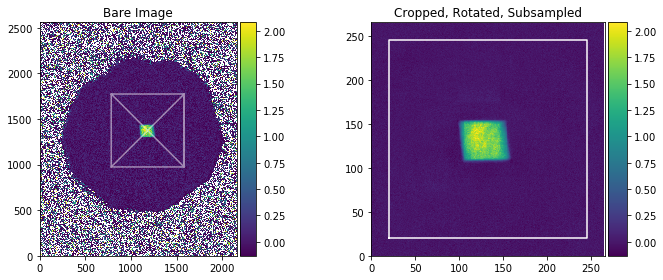

In [47]:
# Define Settings  
settings = {**default_settings, 
            **dict(center_x = 1184, center_y = 1374, width=800, height=800, fudge=1, subsample=3, od_method='table')}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)
    
# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

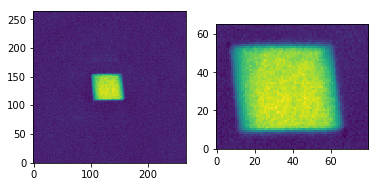

In [48]:
# ROI 
test = 0
center_offset = [0, 0]
width, height = 80, 66
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[0], df.image.iloc[test].od.shape[0]//2 + center_offset[1]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

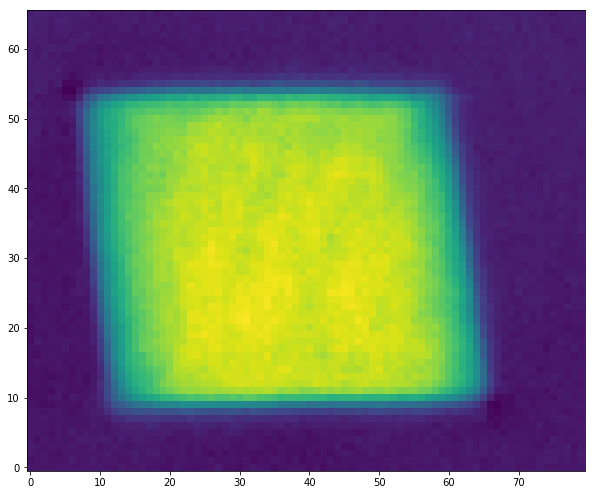

In [49]:
# Averaged Image 
mean_app = np.mean([im.app for im in df.image[0::2]], axis=0)
plt.figure(figsize=[10, 10])
plt.imshow(mean_app[roi], origin=0, )

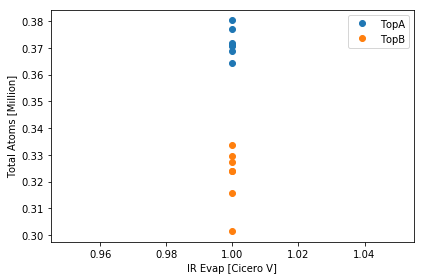

In [50]:
# Atom number vs x 
df['total_atoms'] = [np.nansum(im.app[roi]) for im in tqdm(df.image)]
plt.plot(df['x'].values[::2], df['total_atoms'].values[::2]/1e6,'o', label='TopA')
plt.plot(df['x'].values[1::2], df['total_atoms'].values[1::2]/1e6,'o', label='TopB')
plt.xlabel('IR Evap [Cicero V]')
plt.ylabel('Total Atoms [Million]')
plt.legend()
plt.tight_layout()

### Length, Radius, and Sigma

In [51]:
# Function Definitions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
def fitres_extract(frl, frw):
    length = abs(frl[1] - frl[0])
    sigma = np.mean([abs(frl[2]), abs(frl[3])])
    rad = frw[1]
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (length*pix, rad*pix, sigma*pix)
def circle(x, x0, rad):
    y2 = rad**2 - (x-x0)**2
    y2[y2<=0] = 0
    return y2**0.5
def fitfun_rad(x, x0, rad, amp=1, offset=0):
    return circle(x, x0, rad)*amp + offset

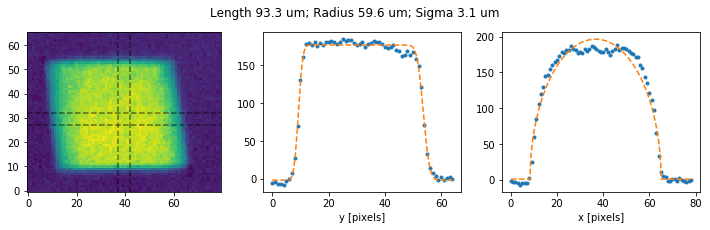

In [52]:
# Box Length and Radius -- Region of Interests 
test = 0
center_offset = [0, -3]
width, height = 6, 6
roi_length = tp.imagedata.get_cropi(df.image.iloc[test].od[roi], 
                                 center=(df.image.iloc[test].od[roi].shape[1]//2 + center_offset[0], df.image.iloc[test].od[roi].shape[0]//2 + center_offset[1]), 
                                 width=width, height=10000)
roi_width = tp.imagedata.get_cropi(df.image.iloc[test].od[roi], 
                                 center=(df.image.iloc[test].od[roi].shape[1]//2 + center_offset[0], df.image.iloc[test].od[roi].shape[0]//2 + center_offset[1]), 
                                 width=10000, height=height)

# Error Function Fits
cl = tp.Curve(y = np.nanmean(df.image.iloc[test].app[roi][roi_length], axis=1))
gl = [cl.maxx/10, cl.maxx/10*9, 5, 5, cl.maxy, cl.maxy/100]
frl = cl.fit(fitfun_erf, gl, plot=False)[0]

# Radius fits
cw = tp.Curve(y = np.nanmean(df.image.iloc[test].app[roi][roi_width], axis=0))
gw = [cw.maxx/2, cw.maxx/2*0.8, cw.maxy, cw.maxy/100]
frw = cw.fit(fitfun_rad, gw, plot=False)[0]

fr = fitres_extract(frl, frw)
suptitle = 'Length {:.1f} um; Radius {:.1f} um; Sigma {:.1f} um'.format(*fr)

fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].imshow(df.image.iloc[test].app[roi], origin=0)
ax[0].axvline(roi_length[1].start, c='k', linestyle='--', alpha=0.5)
ax[0].axvline(roi_length[1].stop-1, c='k', linestyle='--', alpha=0.5)
ax[0].axhline(roi_width[0].start, c='k', linestyle='--', alpha=0.5)
ax[0].axhline(roi_width[0].stop-1, c='k', linestyle='--', alpha=0.5)
ax[1].plot(*cl.data, '.')
ax[1].plot(*cl.xyfitplot, '--')
ax[1].set(xlabel='y [pixels]')
ax[2].plot(*cw.data, '.')
ax[2].plot(*cw.xyfitplot, '--')
ax[2].set(xlabel='x [pixels]')
plt.suptitle(suptitle, y=1.05)
plt.tight_layout()

In [53]:
# Calculate for all 
results = []

for i, im in df.image.iteritems():
    # Error Function Fits
    cl = tp.Curve(y = np.nanmean(im.app[roi][roi_length], axis=1))
    gl = [cl.maxx/10, cl.maxx/10*9, 5, 5, cl.maxy, cl.maxy/100]
    frl = cl.fit(fitfun_erf, gl, plot=False)[0]
    # Radius fits
    cw = tp.Curve(y = np.nanmean(im.app[roi][roi_width], axis=0))
    gw = [cw.maxx/2, cw.maxx/2*0.8, cw.maxy, cw.maxy/100]
    frw = cw.fit(fitfun_rad, gw, plot=False)[0]
    # Store results
    results.append(fitres_extract(frl, frw))

# Store in dataframe
results = np.array(results)
df['length'] = results[:, 0]
df['radius'] = results[:, 1]
df['sigma'] = results[:, 2]

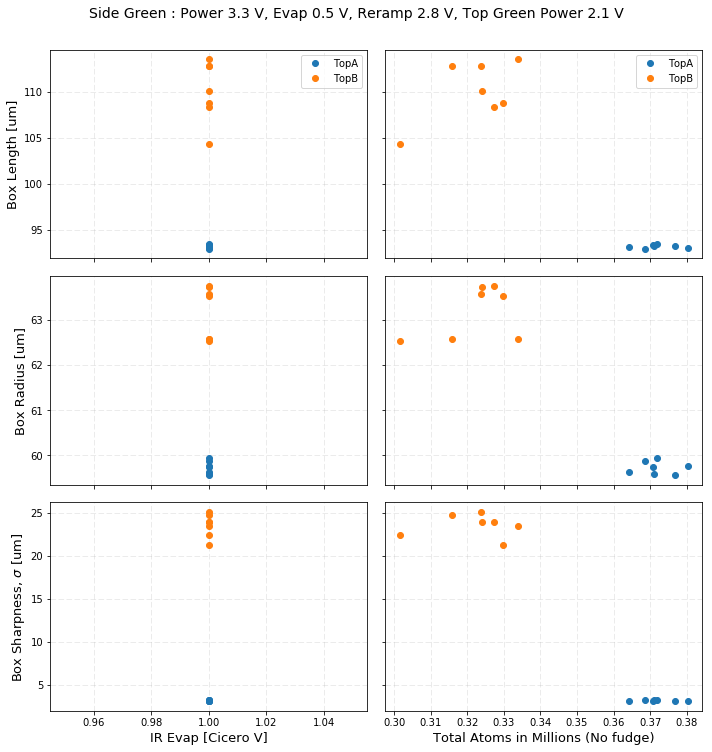

In [54]:
# Plot Results -- TopA and TopB separate, vs x and total_atoms 
vals = np.unique(df.SideGreenPower)[0], np.unique(df.SideGreenEvap)[0], np.unique(df.SideGreenReramp)[0], np.unique(df.TopGreenPower)[0]
suptitle = "Side Green : Power {} V, Evap {} V, Reramp {} V, Top Green Power {} V".format(*vals)
fontsize = 13

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(321)
plt.plot(df.x[::2], df.length[::2], 'o', label='TopA')
plt.plot(df.x[1::2], df.length[1::2], 'o', label='TopB')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Length [um]', fontsize=fontsize)
plt.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(323, sharex=ax1)
plt.plot(df.x[::2], df.radius[::2], 'o')
plt.plot(df.x[1::2], df.radius[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Radius [um]', fontsize=fontsize)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(325, sharex=ax1)
plt.plot(df.x[::2], df.sigma[::2], 'o')
plt.plot(df.x[1::2], df.sigma[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Box Sharpness, $\sigma$ [um]', fontsize=fontsize)
plt.xlabel('IR Evap [Cicero V]', fontsize=fontsize)

ax4 = plt.subplot(322, sharey=ax1)
plt.plot(df.total_atoms[::2]/1e6, df.length[::2], 'o', label='TopA')
plt.plot(df.total_atoms[1::2]/1e6, df.length[1::2], 'o', label='TopB')
plt.grid(linestyle='--', alpha=0.3)
plt.legend()
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

ax5 = plt.subplot(324, sharex=ax4, sharey=ax2)
plt.plot(df.total_atoms[::2]/1e6, df.radius[::2], 'o')
plt.plot(df.total_atoms[1::2]/1e6, df.radius[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

ax6 = plt.subplot(326, sharex=ax4, sharey=ax3)
plt.plot(df.total_atoms[::2]/1e6, df.sigma[::2], 'o')
plt.plot(df.total_atoms[1::2]/1e6, df.sigma[1::2], 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Total Atoms in Millions (No fudge)', fontsize=fontsize)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.03)

plt.suptitle(suptitle, y=1.04, fontsize=14)
plt.tight_layout()

In [55]:
# Print averaged length and radius of TopA 
info = {}
info['radius'] = np.mean(df.iloc[::2].radius.values)
info['radius err'] = np.std(df.iloc[::2].radius.values) 
info['length'] = np.mean(df.iloc[::2].length.values)
info['length err'] = np.std(df.iloc[::2].length.values) 

print("Radius {:.2f} +- {:.2f} um".format(info['radius'], info['radius err']))
print("Length {:.2f} +- {:.2f} um".format(info['length'], info['length err']))

Radius 59.73 +- 0.13 um
Length 93.18 +- 0.16 um


### Outline

In [ ]:
import skimage.filters
import skimage.measure
from skimage.measure import label, regionprops
import math

In [ ]:
test = 0

img = df.image.iloc[test].app[roi]
mask = skimage.filters.threshold_adaptive(img, 51, method='mean')
contours = skimage.measure.find_contours(mask, 0)
label_img = label(mask)
regions = regionprops(label_img)

plt.imshow(img, origin=0)
# plt.imshow(mask, cmap='gray', alpha=0.2, origin=0)
for c in contours:
    plt.plot(c[:,1], c[:,0], '-w')
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    plt.plot(x0, y0, '.r', markersize=15)
    plt.title('Area : {} px^2'.format(props.filled_area))

In [ ]:
# Need to fit lines to the four sides

### Center of the Box

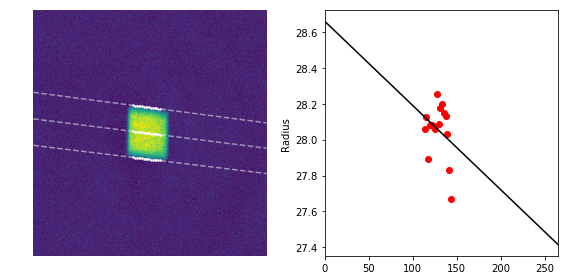

In [69]:
# Adjust parameters for box cross-section
params = dict(xsec_extension='linear', xsec_slice_width=2, xsec_fit_range=1.1, radial_selection=0.5)

def temp_func(test=0,):
    fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
    df.image.iloc[test].set(**params)
    df.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()

if df.shape[0] <= 2:
    temp_func(0)
else:
    ipywidgets.interact(temp_func, test=(0, df.shape[0]-2, 2));

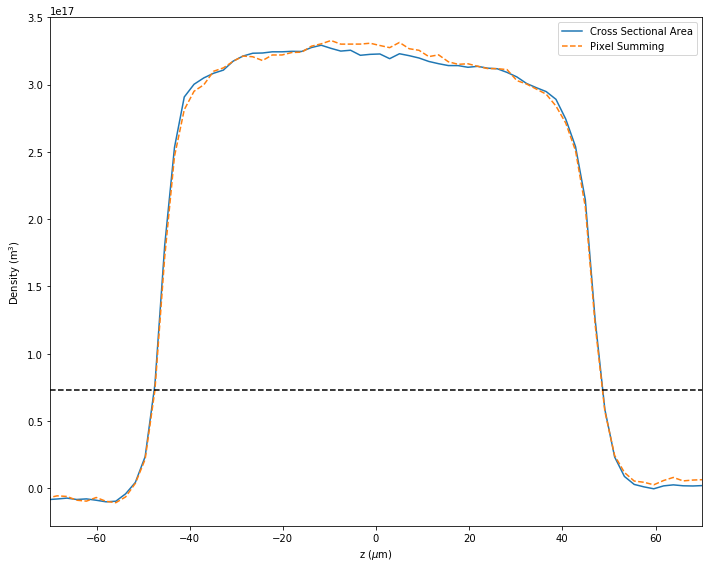

In [70]:
# Average n(z) for all images 
avg_atoms = np.mean([im.total_atoms for im in df.image[::2]])
nz_all = [tp.Curve(im.nz.x*1e6, im.nz.y / im.total_atoms * avg_atoms) for im in df.image[::2]]
nz_conc = tp.Curve(np.concatenate([c.x for c in nz_all]), np.concatenate([c.y for c in nz_all])).sortbyx()
nz = nz_conc.binbyx(bins = nz_all[0].x.size)

# Summing up the pixels for comparison 
Nz_all = [tp.Curve(im.nz.x*1e6, np.mean(im.app, axis=1) / im.total_atoms * avg_atoms) for im in df.image[::2]]
Nz_conc = tp.Curve(np.concatenate([c.x for c in Nz_all]), np.concatenate([c.y for c in Nz_all])).sortbyx()
Nz = Nz_conc.binbyx(bins = Nz_all[0].x.size)
multiplier = nz.y.sum() / Nz.y.sum()

# Plots for comparison
plt.figure(figsize=[10, 8])
plt.plot(*nz.data, label='Cross Sectional Area')
plt.plot(Nz.x, Nz.y * multiplier, '--', alpha=1, label='Pixel Summing')
plt.axhline(0.73e17, c='k', linestyle='--')
plt.legend()
plt.xlim([-70, 70])
plt.xlabel(r'z ($\mu$m)')
plt.ylabel(r'Density (m$^3$)')
plt.tight_layout()


[ -5.95268762e+00  -4.59437931e+01   4.68279704e+01  -1.64053447e+02
   2.57305923e+00   3.03533484e+00   3.25768382e+17  -5.57404202e+13]


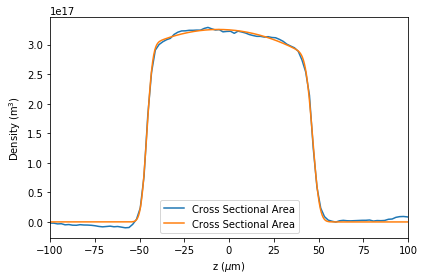

In [71]:
# EXPERIMENTAL -- Fit erf + harmonic confinment 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
def fitfun_erf_harmonic(x, x0, x1, x2, s0, s1, s2, a1=1, offset=0, slope=0):
    y1 = fitfun_erf(x, x1, x2, s1, s2, a1)
    y0 = (1 - ((x-x0)/s0)**2)
    y0[y0<=0] = 0
    return y1 * y0**(3/2) + offset + slope * x

def fitres_extract(frl, frw):
    length = abs(frl[1] - frl[0])
    sigma = np.mean([abs(frl[2]), abs(frl[3])])
    rad = frw[1]
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (length*pix, rad*pix, sigma*pix)

x = nz.x
guess = [-50, -47, 47, 500, 10, 10, 2.5e17, 1e15]
y = fitfun_erf_harmonic(x, *guess)
fr, fe = nz.fit(fitfun_erf_harmonic, guess, plot=False)
print(fr)

# Plots for comparison
plt.plot(*nz.data, label='Cross Sectional Area')
plt.plot(*nz.xyfitplot, label='Cross Sectional Area')
# plt.plot(Nz.x, Nz.y * multiplier, '--', alpha=1, label='Pixel Summing')
plt.legend()
plt.xlim([-100, 100])
plt.xlabel(r'z ($\mu$m)')
plt.ylabel(r'Density (m$^3$)')
plt.tight_layout()

### P(n)

## Box Side - Sharpness, Radii, Ellipticity, P(n)

### Load

In [ ]:
# Load Images 

# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['IRevap','SideGreenEvap','SideGreenPower', 'TopGreenPower', 'SideGreenReramp']
x_var = 'IRevap'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=2, display=True)

In [ ]:
# Define Settings  
settings = {**default_settings, 
            **dict(center_x = 137, center_y = 200, width=200, height=200, fudge=1, subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)
    
# Tests
print("\n============== Testing Crop Settings ==============")
test = 0
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

In [ ]:
# ROI 
test = 0
center_offset = [0, 0]
width, height = 150, 140
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[0], df.image.iloc[test].od.shape[0]//2 + center_offset[1]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

In [ ]:
# Atom number vs x 
df['total_atoms'] = [np.nansum(im.od[roi]) for im in tqdm(df.image)]
plt.plot(df['x'].values, df['total_atoms'].values/1e4,'o')
plt.xlabel('IR Evap [Cicero V]')
plt.ylabel('Total OD [Arb.]')
plt.legend()
plt.tight_layout()

### Outlines

In [ ]:
# Definitions 
import skimage.filters
import skimage.measure
from skimage.measure import label, regionprops
import math

def get_ellipse(img, feature_size=121, method='mean', plot=False, info='Not Provided'):
    # Get outlines
    mask = skimage.filters.threshold_adaptive(img, feature_size, method=method)
    contours = skimage.measure.find_contours(mask, 0)
    label_img = label(mask)
    regions = regionprops(label_img)
    # Error if regions > 1
    if len(regions) > 1:
        print('ERROR : More than 1 region found on {}. Using max area region'.format(info))
        region_area = np.array([props.filled_area for props in regions])
        region = regions[np.argmax(region_area)]
    else:
        region = regions[0]
    # Plot
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img, origin=0)
        for c in contours: plt.plot(c[:,1], c[:,0], '--w')
        y0, x0 = region.centroid
        x1 = x0 + math.cos(region.orientation) * 0.5 * region.major_axis_length
        y1 = y0 - math.sin(region.orientation) * 0.5 * region.major_axis_length
        x2 = x0 - math.sin(region.orientation) * 0.5 * region.minor_axis_length
        y2 = y0 - math.cos(region.orientation) * 0.5 * region.minor_axis_length
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-y', linewidth=2.5)
        plt.show()
    # return the largest region
    pix = df.image.iloc[0].pixel_binned * 1e6
    return (region.major_axis_length/2, region.minor_axis_length/2, 180/np.pi*region.orientation, region.filled_area) 

In [ ]:
# Test 
test = 2
img = df.image.iloc[test].od[roi]
a, b, angle, area = get_ellipse(img, plot=True)

In [ ]:
# Calculate for all 
results = []
for i, r in tqdm(df.iterrows()):
    results.append(get_ellipse(r.image.od[roi], info=i))
results = np.array(results)
df['radius_a'], df['radius_b'], df['angle'], df['filled_area'] = results[:,0], results[:,1], results[:,2], results[:,3]
df['area_ellipse'] = np.pi * df['radius_a'] * df['radius_b']
df['ellipticity'] = df['radius_a'] / df['radius_b']
df.head(2)

In [ ]:
# Plot Results -- TopA and TopB separate, vs x and total_atoms 
vals = np.unique(df.SideGreenPower)[0], np.unique(df.SideGreenEvap)[0], np.unique(df.SideGreenReramp)[0], np.unique(df.TopGreenPower)[0]
suptitle = "Side Green : Power {} V, Evap {} V, Reramp {} V, Top Green Power {} V".format(*vals)
fontsize = 13

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(321)
plt.plot(df.x, df.radius_a, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Major Axis Radius [pixels]', fontsize=fontsize)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(323, sharex=ax1)
plt.plot(df.x, df.radius_b, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Minor Axis Radius [pixel]', fontsize=fontsize)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(325, sharex=ax1)
plt.plot(df.x, df.angle, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.ylabel('Angle of Ellipse [deg]', fontsize=fontsize)
plt.xlabel('IR Evap [Cicero V]', fontsize=fontsize)

ax4 = plt.subplot(322, sharey=ax1)
plt.plot(df.total_atoms/1e4, df.radius_a, 'o', label='r_a')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

ax5 = plt.subplot(324, sharex=ax4, sharey=ax2)
plt.plot(df.total_atoms/1e4, df.radius_b, 'o', label='r_b')
plt.grid(linestyle='--', alpha=0.3)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

ax6 = plt.subplot(326, sharex=ax4, sharey=ax3)
plt.plot(df.total_atoms/1e4, df.angle, 'o')
plt.grid(linestyle='--', alpha=0.3)
plt.xlabel('Total Atoms [Arb.]', fontsize=fontsize)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.03)

plt.suptitle(suptitle, y=1.02, fontsize=14)
plt.tight_layout()

## Box Volume - using Side and Top

## Hybrid Cross Section Area

# Thermodynamics

## Hybrid Thermodynamics - Polarized

## Hybrid Thermodynamics - Balanced

## Density Calibration using $\kappa$ of Polarized Gas

## Box Expansion into Hybrid

Total energy per particle in the Hybrid potential
$$\frac{E}{N} = 2 m \omega^2 \left< z^2 \right> = 4 \left< U \right>$$

Reduced Energy 
$$ \frac{E}{E_0} = \frac{5}{3} \frac{E}{N E_F}$$

Here $  \left< U \right> $ is the normalized averages, normalized by the total atom numbers. 

We will employ two ways to extract the energy. 
* Equation of State Fits
* Second Moment
* Gaussian Fits

In [85]:
# Used Functions 

def compute_moment(nz, zlim=550):
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

def gaussian_fit_sigma(nz, plot=False):
    guess = [1e-6, 20e-6, nz.maxy, nz.maxy/1000]
    fr = nz.fit(gaussian, guess, plot=plot)[0]
    res = np.sum((nz.y - gaussian(nz.x, *fr))**2)
    return (fr[1], res)

def erf(x, x0, sigma):
    return scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, amp, x0, sigma):
    return erf(x, x0, sigma) * amp

def compute_moment_v2(nz, cutoff, plot=False, ax = None):
    # Compute moment vs cutoffs
    zlims = np.linspace(cutoff[0], cutoff[2], 100)
    moment = np.array([abs(compute_moment(nz, zlim=z)) for z in zlims])**0.5 * 1e6
    c_ = tp.Curve(zlims, moment)
    c_.removenan()
    
    # Fit
    sigma = c_.x**2/cutoff[1]**2
    sigma[c_.x <= cutoff[1]] = 1
    fr1 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=[55, 0, 50])[0]
    fr2 = scipy.optimize.curve_fit(fitfun_erf, c_.x, c_.y, p0=fr1, sigma=sigma)[0]
    
    # plot
    if plot:
        if ax is None: ax = plt.subplots()[1]
        ax.plot(*c_.data)
        ax.plot(c_.x, fitfun_erf(c_.x, *fr1), '-.', label='w/o')
        ax.plot(c_.x, fitfun_erf(c_.x, *fr2), label='w/')
        ax.plot(c_.x, 1/sigma * np.mean([fr1[0], fr2[0]]), 'k--', alpha=0.2, label='weight')
        ax.set(ylim=[c_.y.mean() * 0.6, c_.maxy*1.1])
        ax.legend(loc=2)
    
    # return
    return (fr2[0]*1e-6)**2

In [86]:
# One Time Setup 
df = get_from_clipboard(init=True)

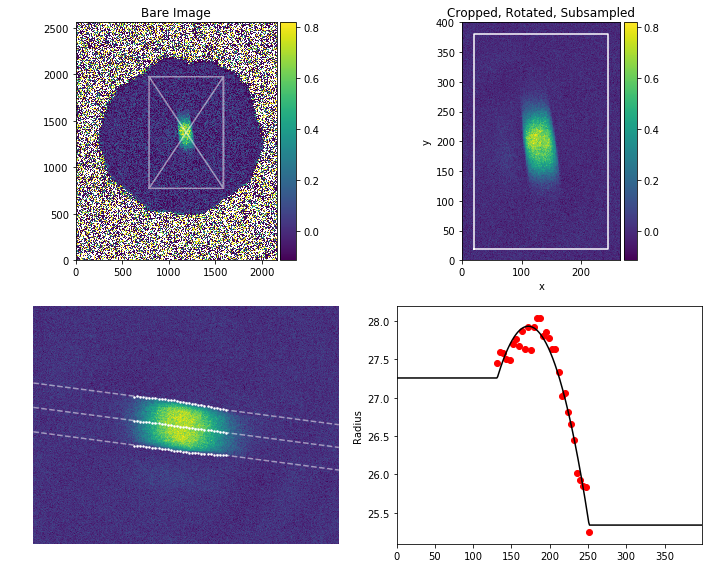

In [87]:
# Load Images 

# Load Images
var = ['ExpansionTime','SideGreenEvap','WaitBox','IREvap','HeatTime','BoxShakeTime', 'ShakingCycles', 'BoxShakeAmp', 'BoxShakeFreq', 'Axial Grad Volt']
# x_var = 'BoxShakeFreq'
x_var = 'HeatCycles'
# x_var = 'ExpansionTime'
# x_var = 'Axial Grad Volt'
# x_var = 'ShakingCycles'
df = get_from_clipboard(df=df, x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=0, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1375, width = 800, height = 1200, fudge = 1.75)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = 0
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
# ax[2].plot(*df.image.iloc[test].nz.plotdata)
# ax[2].set(xlabel='z [um]', ylabel='Density n [um^-3]')
df.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

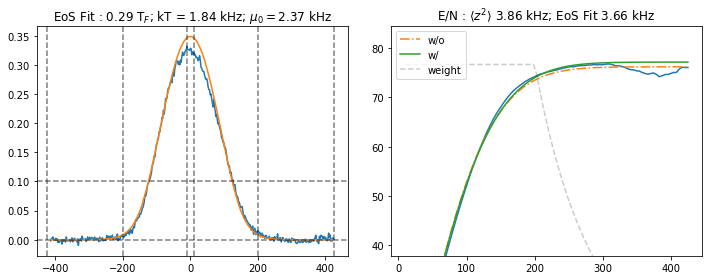

In [88]:
# Test Temperature Fits and Second Moment Limits 

zlim_second_moment = np.array([10, 200, df.image.iloc[0].nz.maxx*1e6])
kHz = 1e3 * cst.h
prefactor = 2 * cst.mass * df.image.iloc[0].trap_w**2

# Test function
def test_func(test=0, ):
    # Get the image and compute it all 
    im = df.image.iloc[test]
    im.T_kHz
    
    # Second moment
    nz = im.nz
    moment = compute_moment_v2(nz, zlim_second_moment)**0.5 * 1e6
    E_N_moment = prefactor * (moment*1e-6)**2 / kHz
    
    # Temperature
    Tfit_info = im.var['Tfit_info']
    nz_fit = tp.Curve(nz.x, Tfit_info[0](nz.x, *Tfit_info[1]), xscale=nz.xscale, yscale = nz.yscale)
    E_N_fit = hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) / kHz
    
    # Plots
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].plot(*nz_fit.plotdata)
    ax[0].axhline(im.Tfit_lim, linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*zlim_second_moment, *-zlim_second_moment]: ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, zlim_second_moment, plot=True, ax=ax[1])
    ax[0].set(title='EoS Fit : {:.2f} T$_F$; kT = {:.2f} kHz; $\mu_0=${:.2f} kHz'.format(im.TTF_center, im.T_kHz, im.mu0_kHz) )
    ax[1].set(title=r"E/N : $\left< z^2 \right>$ {:.2f} kHz; EoS Fit {:.2f} kHz".format(E_N_moment, E_N_fit))
    fig.tight_layout()

if df.shape[0] == 1:
    test_func(0)
else:
    ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1));

In [89]:
# Box Characteristics !!! CRUCIAL 

# Cross section for calculating EoS fit atom numebrs 
cross_section=np.pi*(59.73e-6)**2

# Box Volume for calculating E_F box 
# box_volume = 94.5e-6 * np.pi * (58.3e-6)**2
# box_volume = 95.75e-6 * np.pi * (59.3e-6)**2
box_volume = 93.18e-6 * cross_section



        Total Loaded Images 3
        Atom Num Filter     3
        Removed Images      0
        


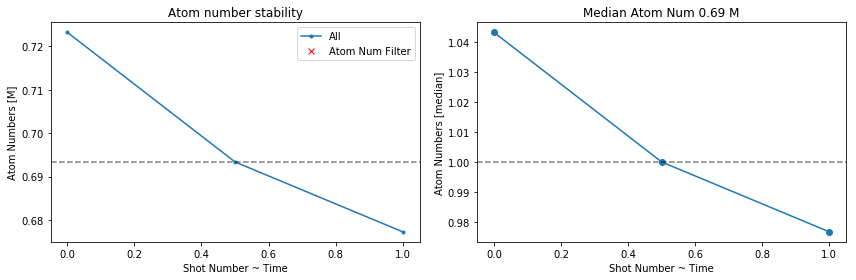

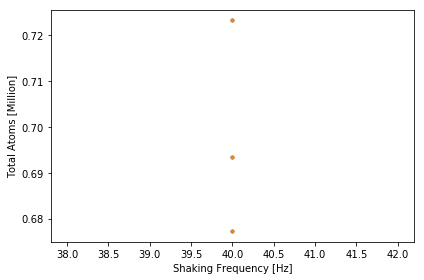

In [90]:
# fit and bin all data 

# Atom Number Filter
df['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df.image, desc='Atoms')])
using = atom_num_filter(df, keep=0.10, offset=0.0)
plt.show()

# using = using & (df['ShakingCycles'].values != 0)
# print('Removed BG Images {}'.format(np.sum(using)))

# Compute E/N for good images
EN_eos = np.array([hybrid_E_N(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f) for im in tqdm(df.image[using], desc='EoS')])
EN_moment = np.array([prefactor * compute_moment_v2(im.nz, zlim_second_moment) for im in tqdm(df.image[using], desc='Moment')])
temp_eos_atoms = np.array([hybrid_total_atoms(im.T_kHz * kHz, im.mu0_kHz * kHz, im.trap_f, cross_section) for im in tqdm(df.image[using], desc='EoS')])

# Bin Data
EN_eos = bin_data(df.x.values[using], EN_eos)
EN_moment = bin_data(df.x.values[using], EN_moment)
total_atoms = bin_data(df.x.values[using], df.total_atoms.values[using])
total_atoms_fit = bin_data(df.x.values[using], temp_eos_atoms)

# Plot atoms vs x 
plt.figure()
plt.plot(df.x, df.total_atoms/1e6,'.')
plt.plot(df.x[using], df.total_atoms[using]/1e6,'.')
plt.xlabel('Shaking Frequency [Hz]')
plt.ylabel('Total Atoms [Million]')
plt.tight_layout()

In [91]:
# Information about the data 
unique, counts = np.unique(total_atoms[4], return_counts=True)
for i in range(unique.size):
    print(unique[i], '--', counts[i])

40.0 -- 3


### Plots 

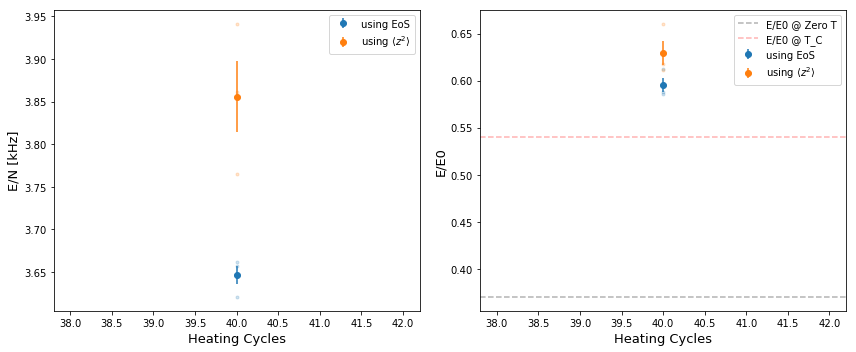

In [92]:
# Simple Plot : E/N and E/E0 vs x_variable 
# xlabel = 'Wait time [s]'
# xlabel = 'Freq [Hz]'
xlabel = 'Heating Cycles'
# xlabel = 'Expansion Time [ms]'
ylabel = 'E/N [kHz]'
fontsize = 13

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.errorbar(EN_eos[0], EN_eos[1]/kHz, yerr=EN_eos[2]/kHz, fmt='oC0', label='using EoS')
plt.plot(EN_eos[4], EN_eos[5]/kHz, '.C0', alpha=0.2)
plt.errorbar(EN_moment[0], EN_moment[1]/kHz, yerr=EN_moment[2]/kHz, fmt='oC1', label = r'using $\left< z^2 \right>$')
plt.plot(EN_moment[4], EN_moment[5]/kHz, '.C1', alpha=0.2)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()

plt.subplot(122)
E_E0 = 5/3 * EN_eos[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_eos = bin_data(EN_eos[4], E_E0)
plt.errorbar(*E_E0_eos[0:3], fmt='o', label='using EoS')
plt.plot(E_E0_eos[4], E_E0_eos[5], '.C0', alpha=0.2)
E_E0 = 5/3 * EN_moment[5] / cst.n2EF(total_atoms_fit[5] / box_volume)
E_E0_moment = bin_data(EN_moment[4], E_E0)
plt.errorbar(*E_E0_moment[0:3], fmt='o', label=r'using $\left< z^2 \right>$')
plt.plot(E_E0_moment[4], E_E0_moment[5], '.C1', alpha=0.2)
plt.axhline(0.37, linestyle='--', color='k', alpha=0.3, label='E/E0 @ Zero T')
plt.axhline(0.54, linestyle='--', color='r', alpha=0.3, label='E/E0 @ T_C')
plt.ylabel('E/E0', fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
# plt.xlim([0, None])
plt.legend()
plt.tight_layout()


In [93]:
# print some info 
print('Fudge : {}'.format(df.image.iloc[0].fudge))
print('Box Volume : {:.0f} um^3'.format(box_volume*1e18))
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
print("T/TF from EoS fit : {:.3f}".format(c(E_E0_eos[1][0])))
print('Fermi Energy : {:.3f} +- {:.3f} kHz'.format(cst.n2EFHz(np.mean(total_atoms[5])/box_volume)/1e3, np.std(cst.n2EFHz(np.array(total_atoms[5])/box_volume)/1e3)))
print("E/N from EoS fit  : {:.3f} +- {:.3f}".format(EN_eos[1][0]/kHz, EN_eos[2][0]/kHz))
print("E/N from moment   : {:.3f} +- {:.3f}".format(EN_moment[1][0]/kHz, EN_moment[2][0]/kHz))
print("E/E0 from EoS fit : {:.3f} +- {:.3f}".format(E_E0_eos[1][0], E_E0_eos[2][0]))
print("E/E0 from moment  : {:.3f} +- {:.3f}".format(E_E0_moment[1][0], E_E0_moment[2][0]))

Fudge : 1.75
Box Volume : 1044378 um^3
T/TF from EoS fit : 0.197
Fermi Energy : 9.757 +- 0.177 kHz
E/N from EoS fit  : 3.646 +- 0.011
E/N from moment   : 3.856 +- 0.042
E/E0 from EoS fit : 0.595 +- 0.007
E/E0 from moment  : 0.630 +- 0.013


### Plots for Difference between Two Points

In [94]:
# EN_eos
# E_E0_eos
dEN_eos = [(EN_eos[1][1] - EN_eos[1][0]) / kHz, (EN_eos[2][1]**2 + EN_eos[2][0]**2)**(1/2) / kHz]
dE_E0_eos = [E_E0_eos[1][1] - E_E0_eos[1][0], (E_E0_eos[2][1]**2 + E_E0_eos[2][0]**2)**(1/2)]

print("Delta E/N  \t{:.4f} +- {:.4f} kHz".format(*dEN_eos))
print("Delta E/E0 \t{:.4f} +- {:.4f}".format(*dE_E0_eos))

IndexError: index 1 is out of bounds for axis 0 with size 1

### Store/Copy Data

In [ ]:
# # Copy data to clipboard for pasting in excel
cols = ['Freq', 'total_atoms', 'EN_eos', 'EN_moment', 'EF']
data = np.array([total_atoms[4], total_atoms[5], EN_eos[5], EN_moment[5], cst.n2EF(total_atoms[5] / box_volume)]).T
index = df.name[using].tolist()
paste = pd.DataFrame(data, columns=cols, index=index).to_clipboard(excel=True,)

In [ ]:
# Copy information to clipboard 
c = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
data = ['Fudge', df.image.iloc[0].fudge, 'Volume', box_volume, 'TTF', c(E_E0_eos[1][0]), 
        'EN_EoS', EN_eos[1][0]/kHz, 'EN_EoS_Err', EN_eos[2][0]/kHz, 
        'EN_moment', EN_moment[1][0]/kHz, 'EN_moment_Err', EN_moment[2][0]/kHz, 
        'EE0_EoS', E_E0_eos[1][0], 'EE0_EoS_Err', E_E0_eos[2][0], 
        'EE0_moment', E_E0_moment[1][0], 'EE0_moment_Err', E_E0_moment[2][0], ]
paste = pd.DataFrame(data).to_clipboard(excel=True, header=False, index=False)

### Tests

* Does Gaussian fit always give the second moment? Check with simulated densities. NO!!
* Effect of zlim for second moment
* Does second moment change with the fudge? It shouldn't!

In [ ]:
# Simulated Densities : Gaussian Fits and Second Moment 
kT = 0.1e3 * cst.h
mu = 3.0e3 * cst.h
trapf=23.35

def test_func(kT = 100, mu = 3000, noise_frac = 100, noise = False, show=False):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n = UFG.density_hybrid(z, kT, mu, trapf)
    if noise:
        n += np.random.normal(scale=n.max()/noise_frac, size=n.size)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)

    E_N_0 = hybrid_E_N(kT, mu, trapf=trapf, simple=False)/cst.h
    if show: print('\nEquation of State : E/N {:.0f} Hz'.format(E_N_0))

    if show: print('\nGaussian Fits')
    Gsize, Gres = gaussian_fit_sigma(nz, plot=False)
    GE_N = 2 * cst.mass * (cst.twopi*trapf)**2 * Gsize**2 / cst.h
    Gerr = (GE_N-E_N_0)/E_N_0*100
    if show: print('\tsize {:.2f} us'.format(Gsize * 1e6))
    if show: print('\tE/N {:.0f} Hz'.format(GE_N))
    if show: print('\t% Diff {:.1f}'.format(Gerr))

    if show: print('\nSecond Moment')
    Msize = compute_moment(nz, nz.maxx*1e6)**0.5
    ME_N = 2 * cst.mass * (cst.twopi*trapf)**2 * Msize**2 / cst.h
    Merr = (ME_N-E_N_0)/E_N_0*100
    if show: print('\tsize {:.2f} us'.format(Msize * 1e6))
    if show: print('\tE/N {:.0f} Hz'.format(ME_N))
    if show: print('\t% Diff {:.1f}'.format(Merr))

    if show: plt.plot(*nz.plotdata, label='Generated Density')
    if show: plt.plot(nz.xyfitplot[0]*1e6, nz.xyfitplot[1]/1e18, label='Gaussian Fit')
    if show: plt.legend()
    if show: plt.show()
        
    if not show: return [Merr, Gerr, Gres]

# # Interactive Widget
ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

# # Gaussian Error vs residual 
# mu = 3e3
# kT = np.linspace(100, 7000, 100)
# res = []
# for kT_ in tqdm(kT):
#     res.append(temp_func(kT_, mu))
# res = np.array(res)
# plt.plot(kT, res[:, 1])

In [ ]:
# Second Moment and zlim for real data 

zlims = np.linspace(200, df.image.iloc[0].nz.maxx*1e6, 100)
def test_func(test=0, fudge=1.0):
    nz = df.image.iloc[test].nz
    nz = tp.Curve(nz.x, nz.y*fudge, xscale=nz.xscale, yscale=nz.yscale)
    moment = np.array([compute_moment(nz, zlim=z) for z in zlims])**0.5 * 1e6

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(*nz.plotdata)
    plt.title('Experimental Data')
    plt.axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [zlims[0], -zlims[0], zlims[-1], -zlims[-1]]:
        plt.axvline(_, linestyle='--',c='k',alpha=0.5)
    plt.subplot(122)
    plt.plot(zlims, moment)

ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1), fudge=(0.2,4,0.2));

In [ ]:
# Second Moment and zlim for simulated data 

def test_func(kT = 100, mu = 3000, noise_frac = 100):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n0 = UFG.density_hybrid(z, kT, mu, trapf)
    n = n0 + np.random.normal(scale=n0.max()/noise_frac, size=n0.size)
    nz0 = tp.Curve(z, n0, xscale=1e-6, yscale=1e18)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)
    
    zlims = np.linspace(200, df.image.iloc[0].nz.maxx*1e6, 100)
    moment0 = compute_moment(nz0, zlim=zlims[-1])**0.5 * 1e6
    moment = np.array([compute_moment(nz, zlim=z) for z in zlims])**0.5 * 1e6

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(*nz.plotdata)
    plt.title('Simulated Data + Gaussian Noise')
    plt.axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [zlims[0], -zlims[0], zlims[-1], -zlims[-1]]:
        plt.axvline(_, linestyle='--',c='k',alpha=0.5)
    plt.subplot(122)
    plt.plot(zlims, moment)
    plt.axhline(moment0, linestyle='--', c='k', alpha=0.5)

ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

In [ ]:
# Second Moment ver 2 and zlim for simulated data 

cutoff = np.array([10, 300, df.image.iloc[0].nz.maxx*1e6])
def test_func(kT=500, mu=3000, noise_frac=50, ):
    kT *= cst.h
    mu *= cst.h
    z = df.image.iloc[0].nz.x
    n0 = UFG.density_hybrid(z, kT, mu, trapf)
    n = n0 + np.random.normal(scale=n0.max()/noise_frac, size=n0.size)
    nz0 = tp.Curve(z, n0, xscale=1e-6, yscale=1e18)
    nz = tp.Curve(z, n, xscale=1e-6, yscale=1e18)
    
    moment0 = compute_moment(nz0, zlim=zlims[-1])**0.5 * 1e6
    moment = compute_moment_v2(nz, cutoff)**0.5 * 1e6

    print("True Size {:.2f} um".format(moment0))
    print("Calc Size {:.2f} um".format(moment))
    print("Fractional Error {:.2f} %".format((moment-moment0)/moment0*100))

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*cutoff, *-cutoff]:
        ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, cutoff, plot=True, ax=ax[1])
    ax[1].axhline(moment0, linestyle='--', c='r', alpha=0.5, label='True Value')
    ax[1].legend()
    ax[0].set(title='Simulated Data + Gaussian Noise')
    fig.tight_layout()

ipywidgets.interact(test_func, kT=(100, 7000, 100), mu=(100, 10000, 100), noise_frac=(10, 200, 10));

In [ ]:
# Second Moment ver 2 and zlim for experimental data 

cutoff = np.array([10, 300, df.image.iloc[0].nz.maxx*1e6])
def test_func(test=0, ):
    nz = df.image.iloc[test].nz
    moment = compute_moment_v2(nz, cutoff)**0.5 * 1e6

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].plot(*nz.plotdata)
    ax[0].axhline(0, linestyle='--',c='k',alpha=0.5)
    for _ in [*cutoff, *-cutoff]:
        ax[0].axvline(_, linestyle='--',c='k',alpha=0.5)
    compute_moment_v2(nz, cutoff, plot=True, ax=ax[1])
    ax[0].set(title='Experimental Data')
    fig.tight_layout()

ipywidgets.interact(test_func, test=(0, df.shape[0]-1, 1),);

## Sliced Hybrid -- very hacky

In [ ]:
# Used Function 

def find_rescaling_simple_lstsq(A, B, cutoff=2000):
    A = A[B < cutoff]
    B = B[B < cutoff]
    def fitfun(x, amp): return B / amp
    c = tp.Curve(y = A)
    fr, fe = c.fit(fitfun, [1,])
    return (fr[0], fe[0])

def erf0(x, x0, sigma, amp=1):
    return -(erf(x, x0, sigma, amp) - 1)/2

def find_rescaling_erf_lstsq(A, B, cutoff=2000, width=200):
    A = A * erf0(B, cutoff, width)
    B = B * erf0(B, cutoff, width)
    def fitfun(x, amp): return B / amp
    c = tp.Curve(y = A)
    fr, fe = c.fit(fitfun, [1,])
    return (fr[0], fe[0])

def find_rescaling_i(i, df, cutoff=2000, width=200):
    A = np.sum(df.image.iloc[i+0].app, axis=1)
    B = np.sum(df.image.iloc[i+1].app, axis=1)
    return find_rescaling_erf_lstsq(A, B, cutoff, width)

In [ ]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'SlicerPower', 'SliceTime', 'SideGreenReramp', 'SideGreenPower','TopGreenPower','ImgPower1','ImgPower2']
x_var = 'SideGreenEvap'
df = get_from_clipboard(x_var = x_var, image_func=tp.Hybrid_Image, var=var, using=2, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1117, center_y = 1290, width = 600, height = 1200)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = 1
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
df.image.iloc[test].xsec.infoplot(axs = [ax[2],ax[3]])
plt.tight_layout()
plt.show()

In [ ]:
# Things that are changing
# SideGreenEvap, IREvap, HeatWait, 
# df

### Specific Specialized Analysis

In [ ]:
# # Atom Numeber differences between TopA and TopB 
# total_atoms = np.array([im.total_atoms for im in tqdm(df.image)])
# imbalance = (total_atoms[::2] - total_atoms[1::2]) / (total_atoms[::2] + total_atoms[1::2])

# data = pd.DataFrame(dict(SideGreenEvap = df.SideGreenEvap.values[::2], 
#                          IREvap = df.IREvap.values[::2], 
#                          HeatWait = df.HeatWait.values[::2], 
#                          total_atoms = total_atoms[::2] + total_atoms[1::2], 
#                          imbalance=imbalance))
# uSGE = np.unique(data.SideGreenEvap)
# uIR = np.unique(data.IREvap)
# uHW = np.unique(data.HeatWait)
# print('Unique SideGreenEvap \t', uSGE)
# print('Unique IREvap \t\t', uIR)
# print('Unique HeatWait \t', uHW)


# # Plots vs IREvap for diff settings 
# for u in uSGE:
#     d = data[data.SideGreenEvap == u]
#     plt.plot(d.IREvap, d.imbalance, 'o', label='SGE = {}'.format(u))
# plt.legend()
# plt.axhline(0, linestyle='--', c='k')
# plt.xlabel('IR Evap')
# plt.ylabel('Imbalance')
# plt.title('Scatter in Imbalance')
# plt.tight_layout()
# plt.show()

In [ ]:
# Scaling factor vs various things 
total_atoms = np.array([im.total_atoms for im in tqdm(df.image)])
scaling_factor = np.array([find_rescaling_erf_lstsq(np.sum(imA.app, axis=1), np.sum(imB.app, axis=1), cutoff=3500, width=300)[0] for (imA, imB) in zip(df.image.iloc[0::2], df.image.iloc[1::2])])

data = pd.DataFrame(dict(SideGreenEvap = df.SideGreenEvap.values[::2], 
                         IREvap = df.IREvap.values[::2], 
                         HeatWait = df.HeatWait.values[::2], 
                         total_atoms = total_atoms[::2] + total_atoms[1::2], 
                         scaling_factor=scaling_factor))
uSGE = np.unique(data.SideGreenEvap)
uIR = np.unique(data.IREvap)
uHW = np.unique(data.HeatWait)
print('Unique SideGreenEvap \t', uSGE)
print('Unique IREvap \t\t', uIR)
print('Unique HeatWait \t', uHW)


# Plots vs IREvap for diff settings 
for u in uSGE:
    d = data[data.SideGreenEvap == u]
    plt.plot(d.IREvap, d.scaling_factor, 'o', label='SGE = {}'.format(u))
plt.legend()
plt.xlabel('IR Evap')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factor for Slicing')
plt.tight_layout()
plt.show()

In [ ]:
# EoS fit 
# fudge = 2.3
# fudge = 2
fudge = 3
test = 8 *2
rescaling_factor = find_rescaling_i(test, df, cutoff=3500, width=300)[0]

# Prepare Image B
imB = tp.Hybrid_Image(df.image.iloc[test+1].name, **settings)
imB.set(fudge = fudge)
imB.plot_hybrid_temp_info()

# Prepare Image A
imA = tp.Hybrid_Image(df.image.iloc[test+0].name, xsec_override=imB.xsec, trap_center_override=imB.trap_center, **settings)
imA.set(fudge = fudge * rescaling_factor * 0.95, radial_selection = 0.5)
imA.plot_hybrid_temp_info()


### Tests

In [ ]:
# Simple rescaling factor -- Doesn't work so great 
def test_func(test = 0, cutoff = 2000, ):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = B[B<cutoff].sum() / A[B<cutoff].sum()
    plt.plot(A*rescaling_factor)
    plt.plot(B)
    plt.plot(A, '--')
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.show()
ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100));

In [ ]:
# Minimizing sum of diff. square  
test = 0
cutoff = 2000
def test_func(test = 0, cutoff = 2000, ):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = find_rescaling_simple_lstsq(A, B, cutoff)[0]
    plt.plot(A*rescaling_factor, label='Rescaled S1')
    plt.plot(B, label='S3')
    plt.plot(A, '--', label='Sliced S1')
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.legend()
    plt.show()

ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100));


In [ ]:
# Minimizing sum of diff. square with error function cutoff 
test = 0
cutoff = 2000
width = 200

A = np.sum(df.image.iloc[test+0].app, axis=1)
B = np.sum(df.image.iloc[test+1].app, axis=1)

def test_func(test = 0, cutoff = 2000, width = 100):
    A = np.sum(df.image.iloc[test+0].app, axis=1)
    B = np.sum(df.image.iloc[test+1].app, axis=1)
    rescaling_factor = find_rescaling_erf_lstsq(A, B, cutoff, width)[0]
    plt.plot(A*rescaling_factor, label='Rescaled S1')
    plt.plot(B, label = 'Reference S3')
    plt.plot(A, '--', label='Sliced S1')
    plt.legend()
    plt.axhline(cutoff, c='k', linestyle='--', )
    plt.title('Rescaling Factor {:.2f}'.format(rescaling_factor))
    plt.show()

ipywidgets.interact(test_func, test=(0, df.shape[0]-2, 2), cutoff=(500, 6000, 100), width=(50, 1000, 50));



In [ ]:
# cutoff vs scaling 


# Momentum Distribution

## Ideal Fermi Gas

## Unitary Fermi Gas

## Density Calibration using Fermi-Dirac

# Rapid Ramp

## Top Rapid Ramp Angle

Daily Calculations v2

## Condensate Fraction - Top Focused Rapid Ramp 

In [71]:
# Function definition for cond frac 
def get_cond_frac(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[1]

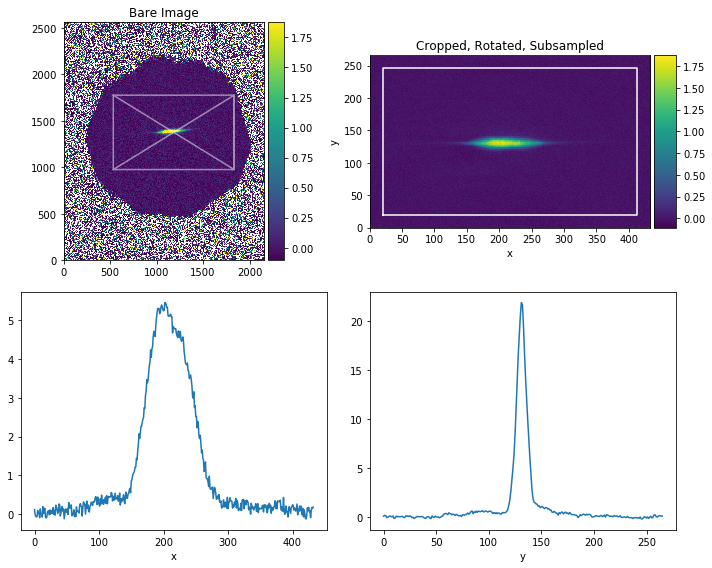

In [76]:
# Load Images 

# Load Images
var = ['IREvap', 'SideGreenEvap', 'HeatWait', 'ShakingCycles']
x_var = 'HeatCycles'
df = get_from_clipboard(x_var = x_var, var=var, using=0, display=False)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1184, center_y = 1377, width = 1300, height = 800, 
                   rotate = 5)}
for i, r in df.iterrows(): r.image.set(**settings)

# Test
test = 0
ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[1].set(xlabel='x', ylabel='y')
ax[2].plot(np.nanmean(df.image.iloc[test].app, axis=0))
ax[3].plot(np.nanmean(df.image.iloc[test].app, axis=1))
ax[2].set(xlabel='x')
ax[3].set(xlabel='y')
plt.tight_layout()
plt.show()

# Total Atoms
df['total_atoms'] = np.array([np.nansum(im.app) for im in tqdm(df.image, desc='Atoms')])

Condensate Fraction 0.75 for x_var 0.0


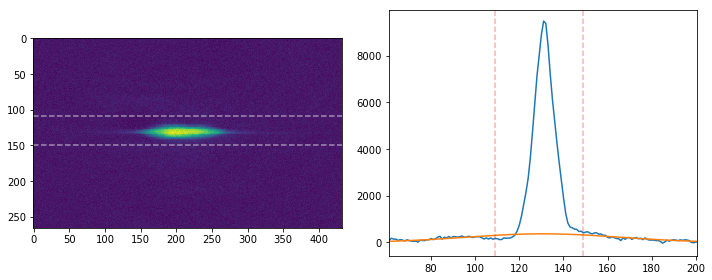

In [77]:
# Condensate Fraction sampler 
cond_frac_center = df.image.iloc[0].app.shape[0]//2 - 4
width = 20
plot_width = 70
thermal_limits = [cond_frac_center - width, cond_frac_center + width]

def temp_func(test = 0):
    cond_frac, sigma = get_cond_frac(df.image.iloc[test].app, thermal_limits, True, plot_width)
    print('Condensate Fraction {:.2f} for x_var {}'.format(cond_frac, df.x.iloc[test]))
if df.shape[0]==1:
    temp_func(0)
else:
    ipywidgets.interact(temp_func, test=(0, df.shape[0]-1, 1));

In [78]:
# fit and bin all data 

# Fit for cond frac 
fit_results = [get_cond_frac(im.app, thermal_limits) for im in df.image]
fit_results = np.array(fit_results)
df['cond_frac'] = fit_results[:,0] 
df['sigma'] = fit_results[:, 1] * df.image.iloc[0].pixel_binned * 1e6 # in um

# bin cond fraction -- binned data ==> [0:x, 1:y_mean, 2:y_err, 3:y, 4:x_all, 5:y_all]
cond_frac_binned = bin_data(df.x.values, df.cond_frac.values)
Tstar_binned = bin_data(df.x.values, df.sigma.values**2 / 1000)
total_atoms_binned = bin_data(df.x.values, df.total_atoms.values/1e6)

### Plots

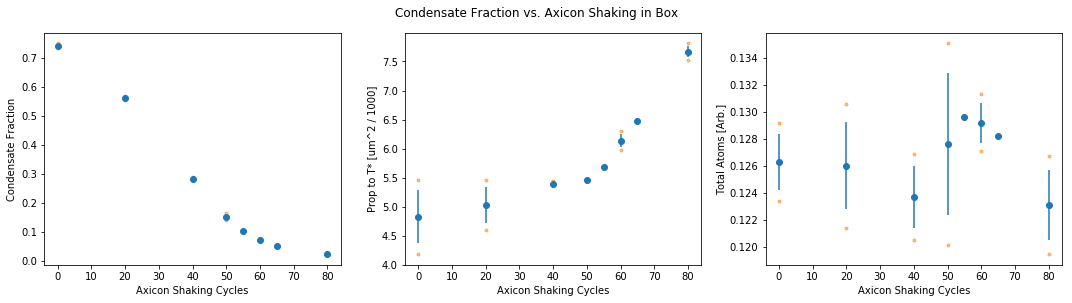

In [84]:
# Simple Plot : {Cond Frac, T*, Atom #} vs x 

# User input
subplot, figsize = 130, (15, 4)
# subplot, figsize = 310, (5, 10)
suptitle = 'Condensate Fraction vs. Axicon Shaking in Box'
# xlabel = 'Heat Wait [s]'
xlabel = 'Axicon Shaking Cycles'
xlim = [None, None]

# Plotter
plt.figure(figsize=figsize)

plt.subplot(subplot+1)
plt.errorbar(*cond_frac_binned[0:2], yerr = cond_frac_binned[2], fmt='o')
plt.plot(*cond_frac_binned[4:6], '.', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Condensate Fraction')

plt.subplot(subplot+2)
plt.errorbar(*Tstar_binned[0:2], yerr = Tstar_binned[2], fmt='o')
plt.plot(*Tstar_binned[4:6], '.', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Prop to T* [um^2 / 1000]')

plt.subplot(subplot+3)
plt.errorbar(*total_atoms_binned[0:2], yerr = total_atoms_binned[2], fmt='o')
plt.plot(*total_atoms_binned[4:6], '.', alpha=0.5)
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('Total Atoms [Arb.]')

plt.suptitle(suptitle, y=1.04)
plt.tight_layout()

In [45]:
# Cond frac vs T* 

# Animation

## Animation - Images with Labels Only

## Animation - Curves

## Animation

# Uncategorized

## Density Difference : TopA - TopB

## Imaging Intensity vs Volt

## Maximum Absorption

# Small Random Calculations

## Atom Number Fluctuations at Different Imaging Freq. -- Side Imaging

In [ ]:
# Entire Code Here 

print("\n============== LOADING IMAGES ==============")
# Initialize Dataframe
df = get_from_clipboard(init=True)
var = ['ImagFreq1','ImagFreq2','ImgPower1','ImgPower2']
x_var = 'ImagFreq1'

df = get_from_clipboard(var=var, x_var=x_var, image_func=tp.Image, using=2)
print("Total Images {}".format(df.shape[0]))
plt.show()

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 115, center_y = 354, width=190, height=190, 
                   subsample=1, od_method='log', bg_width=10)}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
print("\n============== Testing Crop Settings ==============")
test = -1
print(df.image.iloc[test].name)
print(df.x.iloc[test])
df.image.iloc[test].plot_crop()
plt.show()

# ROI
print("\n============== Testing Region Of Interest ==============")
center_offset = [0, 0]
width, height = 80, 80
roi = tp.imagedata.get_cropi(df.image.iloc[test].od, 
                             center=(df.image.iloc[test].od.shape[1]//2 + center_offset[1], df.image.iloc[test].od.shape[0]//2 + center_offset[0]), 
                             width=width, height=height)
fig, ax = plt.subplots(figsize=(6,3), ncols=2)
ax[0].imshow(df.image.iloc[test].od, origin='lower')
ax[1].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Total Atoms 
print("\n============== Atom Nums ==============")
def imsum(od):
    od = od[roi]
    od = od[np.abs(od) < 10000]
    return np.nansum(od)
df['total_atoms'] = np.array([imsum(im.od) for im in df.image])

# Gather atom numbers with same x -- [x, y_mean, y_err, y, x_all, y_all]
atoms_binned = bin_data(df.x.values, df.total_atoms.values)

# Plots
plt.violinplot(atoms_binned[3], atoms_binned[0], showextrema=True, showmeans=True)
plt.plot(*atoms_binned[4:6], '.')
plt.xlabel('Imaging Frequency [Cicero Double Pass]')
plt.ylabel('Atom Numbers [Sum of OD]')
plt.title('Fluctuations in Atom Numbers on and away from Resonance')
plt.tight_layout()
plt.show()

# Display Information of the sigma and mean 
for x, y in zip(atoms_binned[0], atoms_binned[3]):
    print("Freq {} : Samples {:02d}; Mean {:.0f}; std. {:.0f}; std/mean {:.2f}".format(x, y.size, y.mean(), y.std(), y.std() / y.mean()))

## Simple Atom Numbers - Top

In [ ]:
# Complete Procedure 

# Load Images
var = ['ShakeWait']
x_var = 'ShakeWait'

# var = ['SideGreenEvap']
# x_var = 'SideGreenEvap'

df = get_from_clipboard(var=var, x_var=x_var)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1155, center_y = 1314, width = 1200, height = 1200, 
                   subsample = 3, bg_width = 10, od_method = 'table', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 350, 250
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Total Atoms
df['total_atoms'] = np.array([np.nansum(im.app[roi]) for im in tqdm(df.image, desc='Atoms')])

# Plots
plt.plot(df.shot, df.total_atoms/1e6)
plt.xlabel('Shot Number ~ Time')
plt.ylabel('Atom Numbers [Millions]')

In [ ]:
# Plot -- Atom numbers vs x 
xvar = x_var
atoms_x = tp.Curve(x = df[xvar].iloc[::2].values, y = df.total_atoms.iloc[::2].values + df.total_atoms.iloc[1::2].values, yscale=1e6).sortbyx()
plt.plot(*atoms_x.plotdata, '.')
plt.xlabel(xvar)
plt.xlim([None,None])
plt.ylabel('Total Atoms N1 + N3 [Milliions]')
plt.show()

In [ ]:
atoms_x.plotdata[1]
def expdecay(t,a,tau):
    return np.exp(-t/tau)*a
fitres,J=scipy.optimize.curve_fit(expdecay,atoms_x.plotdata[0],atoms_x.plotdata[1],[3,20])
xfit=np.linspace(0,35,100)
yfit=expdecay(xfit,fitres[0],fitres[1])
plt.plot(*atoms_x.plotdata, '.')
plt.plot(xfit,yfit)
plt.xlabel('ODT wait time')
plt.xlim([None,None])
plt.ylabel('Total Atoms N1 + N3 [Milliions]')
plt.show()
print('Life time: {}ms',fitres[0])  


In [ ]:
# # Specialized Plot -- Fractional Imbalance vs. total atoms 

# # Gather Data
# x1 = []
# x2 = []
# y1 = []
# for i in tqdm(range(df.shape[0]//2)):
#     xi = (df.image.iloc[2*i].total_atoms + df.image.iloc[2*i+1].total_atoms)
#     yi = (df.image.iloc[2*i].total_atoms - df.image.iloc[2*i+1].total_atoms) / xi
#     x1.append(xi / 1e6)
#     x2.append(df.IREvap.iloc[2*i])
#     y1.append(yi)

# imbalance_atoms = tp.Curve(np.array(x1), np.array(y1)).sortbyx()
# imbalance_IR = tp.Curve(np.array(x2), np.array(y1)).sortbyx()

# # Compute histogram and Gaussian Fit for values below some IR Evap Threshold 
# IR_threshold = 4
# imbalance_threshold = 0.3
# imbalance_atoms_below = imbalance_atoms.trim(xlim = [0, IR_threshold])
# stats = [np.mean(imbalance_atoms_below.y), np.std(imbalance_atoms_below.y)]
# suptitle = 'Below {} IR Evap, the Mean Imbalance = {:.2f} and std. = {:.2f}'.format(IR_threshold, *stats)

# # Plots
# plt.figure(figsize=(10, 4))
# ax1 = plt.subplot(121)
# plt.plot(*imbalance_atoms.data, '.')
# plt.axhline(0, linestyle='--', c='k', alpha=0.5)
# plt.xlabel('Total Atoms N1 + N3 [Millions]')
# plt.xlim([0,None])
# plt.ylabel('Imbalance (N1 - N3) / (N1 + N3) ')

# ax2 = plt.subplot(122, sharey = ax1)
# plt.semilogx(*imbalance_IR.data, '.')
# # plt.plot(*imbalance_IR.data, '.')
# plt.axhline(0, linestyle='--', c='k', alpha=0.5)
# plt.xlabel('IR Evap [Cicero V]')
# plt.xlim([0.1, None])

# plt.suptitle(suptitle, y = 1.04)
# plt.tight_layout()

In [ ]:
# # Plots
# mask=[0,2,4,6]
# num=np.mean(df.total_atoms[mask]/1e6)
# numerr=np.std(df.total_atoms[mask]/1e6)

# plt.plot(df.shot[mask], df.total_atoms[mask]/1e6)
# plt.xlabel('Shot Number ~ Time')
# plt.ylabel('Atom Numbers [Millions]')

# print('''Atom number = {:.3f} +/- {:.3f}'''.format(num,numerr))

## Averaged Image - Top


Updating the local database...
Done


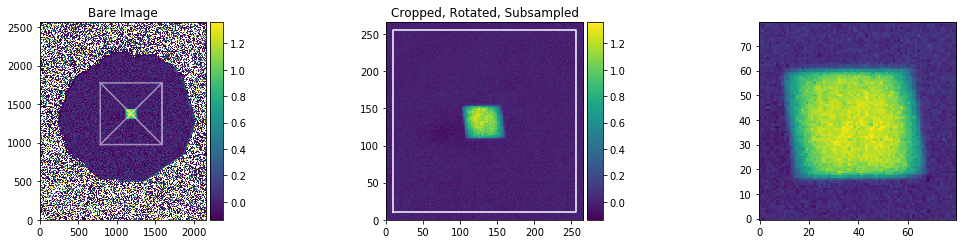

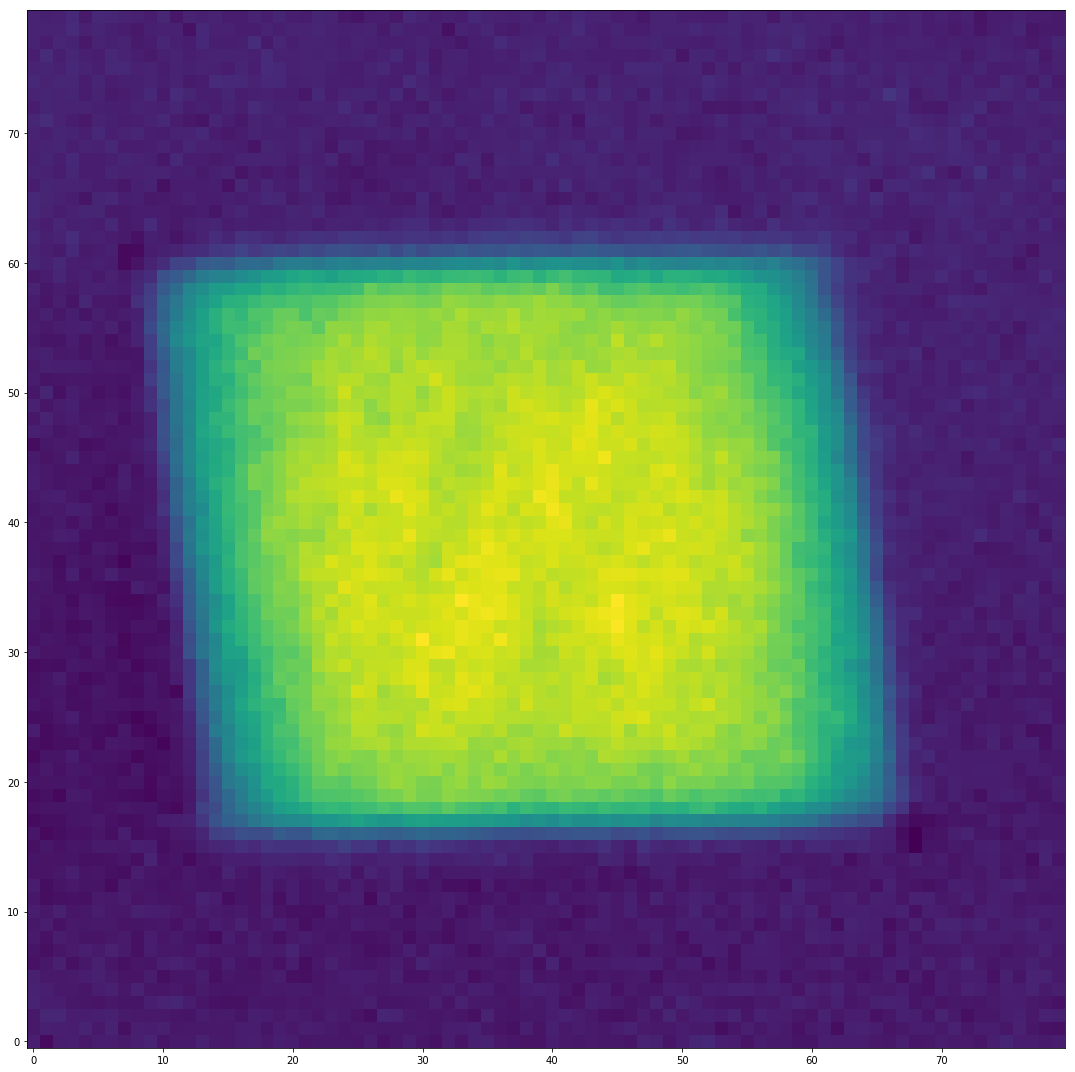

In [14]:
# Complete Procedure 

# Load Images
df = get_from_clipboard(using=0)

# Crop images
settings = {**default_settings, 
            **dict(center_x = 1185, center_y = 1375, width = 800, height = 800, 
                   subsample = 3, bg_width = 10, od_method = 'table', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 80, 80
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Average Image
avg_app = np.mean([im.app[roi] for im in df.image], axis=0)

# Plots
plt.figure(figsize=[15,15])
plt.imshow(avg_app, origin=0)
plt.tight_layout()

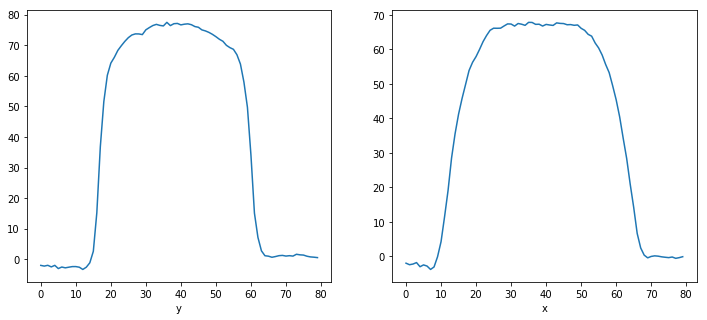

In [15]:
# Cuts through center 
thickness = 5

fig, ax = plt.subplots(ncols=2, figsize=[12, 5])
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=thickness, height=height)
ax[0].plot(np.mean(avg_app, axis=1))
ax[0].set(xlabel='y')
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=thickness)
ax[1].plot(np.mean(avg_app, axis=0))
ax[1].set(xlabel='x')

## Averaged Image - Side


Updating the local database...
Done


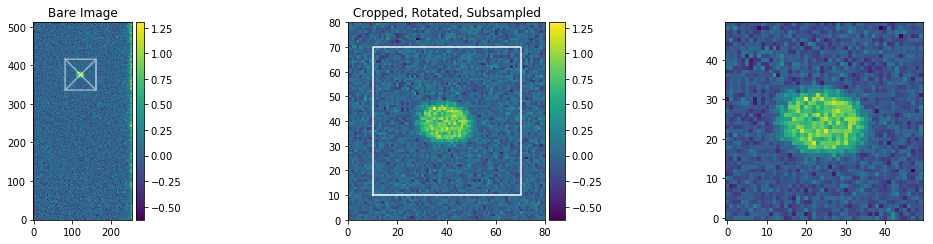

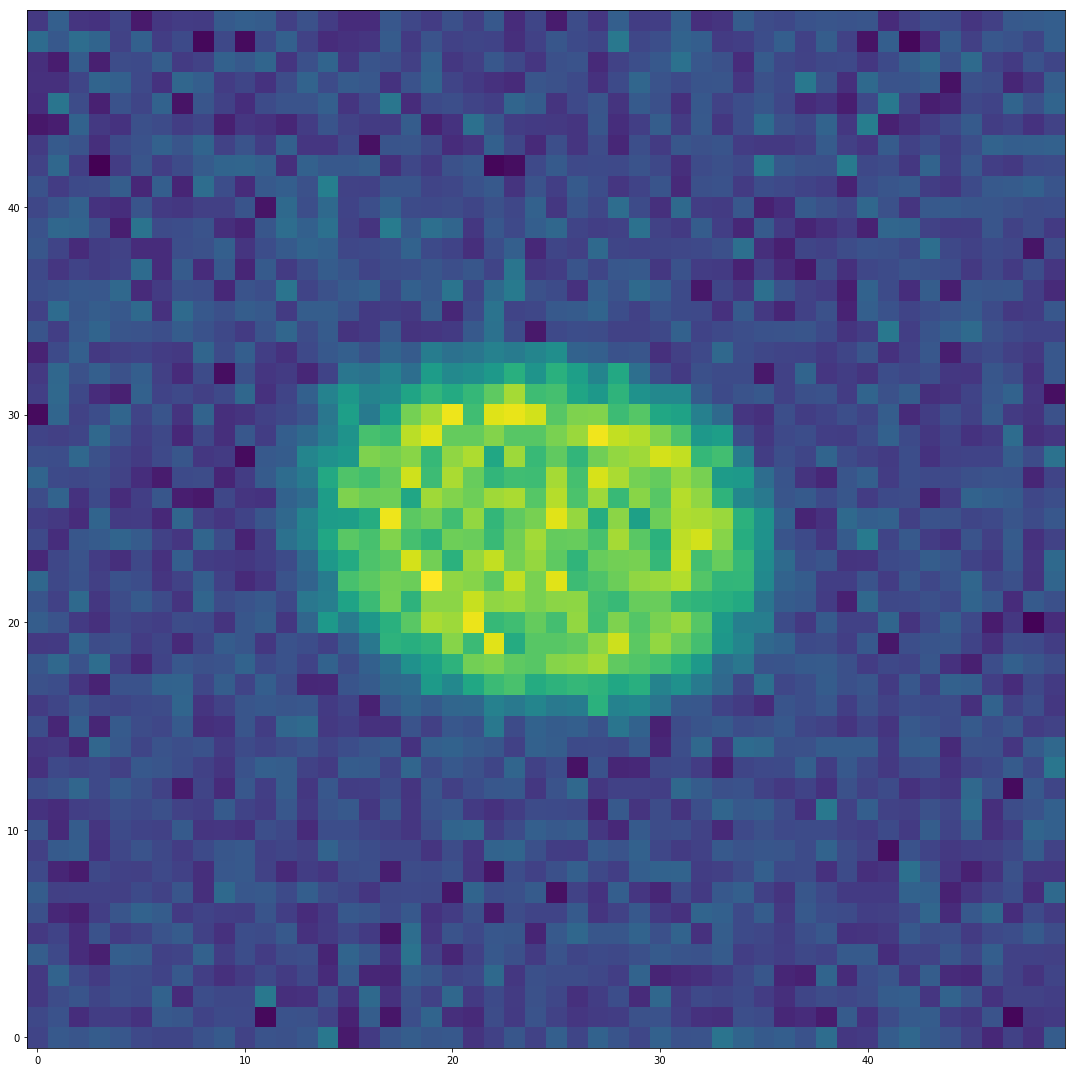

In [315]:
# Complete Procedure 

# Load Images
df = get_from_clipboard()

# Crop images
settings = {**default_settings, 
            **dict(center_x = 122, center_y = 376, width = 80, height = 80, 
                   subsample = 1, bg_width = 10, od_method = 'log', fudge=1)}
for i, r in df.iterrows(): r.image.set(**settings)

# ROI
center_offset = [0, 0]
width, height = 50, 50
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=height)

# Test
test = 0
fig, ax = plt.subplots(ncols=3, figsize=(15, 3.5))
df.image.iloc[test].plot_crop(ax=ax[0:2])
ax[2].imshow(df.image.iloc[test].od[roi], origin='lower')
plt.show()

# Average Image
avg_app = np.mean([im.app[roi] for im in df.image], axis=0)

# Plots
plt.figure(figsize=[15,15])
plt.imshow(avg_app, origin=0)
plt.tight_layout()

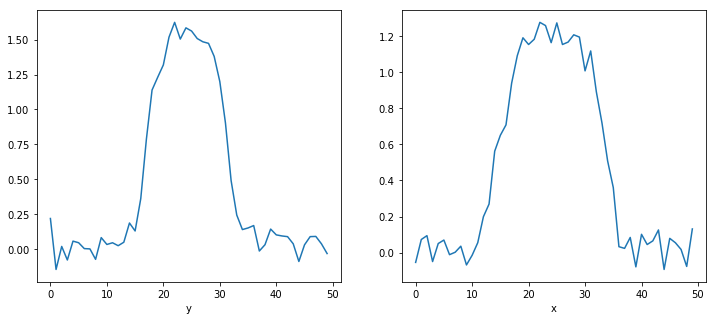

In [316]:
# Cuts through center 
thickness = 0
center_offset = [0,0]

fig, ax = plt.subplots(ncols=2, figsize=[12, 5])
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=thickness, height=height)
ax[0].plot(np.mean(avg_app, axis=1))
ax[0].set(xlabel='y')
roi = get_roi(df.image.iloc[0].app, center=center_offset, width=width, height=thickness)
ax[1].plot(np.mean(avg_app, axis=0))
ax[1].set(xlabel='x')

# Fine Calculations

In [ ]:
1 -1 

In [ ]:
2 * 0

In [ ]:
0**10

In [ ]:
round(np.sin(np.pi))

In [ ]:
round(np.exp(1j*np.pi) + 1)

In [ ]:
np.log(1)

In [ ]:
1/np.inf

# Hyperfine Calculations

## Making Plots using Stored Data

In [ ]:
# saved_DS4 = cond_frac_binned
# saved_DS7 = cond_frac_binned
# saved_DS47 = cond_frac_binned

In [ ]:
fontsize = 14

plt.figure(figsize=[6,5])
# plt.errorbar(*saved_DS4[0:2], yerr = saved_DS4[2], fmt='o-', label='DS4 - Beginning')
# plt.errorbar(*saved_DS7[0:2], yerr = saved_DS7[2], fmt='o-', label='DS7 - End')
plt.errorbar(*saved_DS47[0:2], yerr = saved_DS47[2], fmt='o-', label='Combined')
plt.xlabel('Wait time in Box [s]', fontsize=fontsize)
plt.ylabel('Condensate Fraction', fontsize=fontsize)
# plt.title('at Beginning and End of Datasets', fontsize=15)
plt.legend()
plt.ylim([0,None])
plt.tight_layout()

## Contact Plots

In [ ]:
import virial

In [ ]:
dfold = pd.read_clipboard()
c = t`ap.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
dfold['T/TF'] = c(dfold['E/E0'].values)

In [ ]:
dfnew = pd.read_clipboard()
cnew = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
dfnew['T/TF'] = cnew(dfnew['E/E0'].values)

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)

plt.errorbar(dfold['T/TF'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
plt.errorbar(dfnew['T/TF'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'bo', label='06-01')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlim([0,0.7])

plt.xlabel('T/T$_F$', fontsize=17)
plt.ylabel('C / N k$_F$', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# # Virial plotting
# plt.xlim([0,1.7])
# plt.ylim([1,3.7])
# vir = virial.VirialUnitarity(BetaMuRange=[-5,0])
# CvT = vir.TTilde
# CvC = vir.CI_NkF
# plt.plot(CvT, CvC,'g-', linewidth=2, label='3rd order virial')


# plt.legend()
plt.tight_layout()
plt.savefig('contact.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)
df_main = pd.concat([dfold,dfnew])
plt.errorbar(df_main['T/TF'], df_main['Contact'], df_main['Contact_Error'], fmt = 'bo', label='data')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlim([0,0.7])

plt.xlabel('T/T$_F$', fontsize=17)
plt.ylabel('C / N k$_F$', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Virial plotting
plt.xlim([0,1.7])
plt.ylim([1,3.7])
vir = virial.VirialUnitarity(BetaMuRange=[-5,0])
CvT = vir.TTilde
CvC = vir.CI_NkF
plt.plot(CvT, CvC,'g-', linewidth=2, label='3rd order virial')


plt.legend()
plt.tight_layout()
plt.savefig('contact_with_virial.pdf')

In [ ]:
dfold['EF'] 

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], ncols=1, sharey=True)

plt.plot(dfold['EF'], dfold['Contact'],'ro', label='05-31')
plt.plot(dfnew['EF'], dfnew['Contact'], 'bo',label='06-01')
plt.axvline(0.17, linestyle='--', color='r', alpha=0.5)
plt.xlabel('T/T$_F$', fontsize=15)
plt.ylabel('C / N k$_F$', fontsize=15)

plt.legend()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=[10, 4], ncols=2, sharey=True)

ax[0].errorbar(dfold['E/E0'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
ax[0].errorbar(dfnew['E/E0'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'ro', label='06-01')

ax[0].axvline(0.37, linestyle='--', c='k', alpha=0.5)
ax[0].axvline(0.54, linestyle='--', color='r', alpha=0.5)
ax[0].set_xlabel('E/E$_0$', fontsize=15)
ax[0].set_ylabel('C / N k$_F$', fontsize=15)

ax[0].legend()

ax[1].errorbar(dfold['T/TF'], dfold['Contact'], dfold['Contact_Error'], fmt = 'bo', label='05-31')
ax[1].errorbar(dfnew['T/TF'], dfnew['Contact'], dfnew['Contact_Error'], fmt = 'ro', label='06-01')
ax[1].axvline(0.17, linestyle='--', color='r', alpha=0.5)
ax[1].set_xlabel('T/T$_F$', fontsize=15)

plt.legend()

plt.tight_layout()

In [ ]:
dfnew['T/TF']

## bec lifetime

In [ ]:
# Initialize Dataframe 
df = get_from_clipboard(init=True)
var = ['waittime']
x_var = 'waittime'

# Import from Clipboard
df = get_from_clipboard(df=df, init=False, var=var, x_var=x_var, image_func=tp.Image, using=2)

# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 380, center_y = 80, width=240, height=1000, bg_width=0, subsample=1, od_method='log')}

# Apply settings
for i, r in df.iterrows():
    r.image.set(**settings)

# Tests
test = -1
print(df.image.iloc[test].name)
df.image.iloc[test].plot_crop()
print(df.x.iloc[test])

In [ ]:
# Fits and calc atom nums 
guess = [110, 300, 100, 100, 1, 0]
def atom_num_calc(od, plot=False):
    fr = fit_gaussian_2d(np.nan_to_num(od), plot=plot, guess=guess, )
    return fr[2] * fr[3] * fr[4]
df['total_atoms'] = [atom_num_calc(im.od, plot=True) for im in tqdm(df.image)]
lifetime_curve = tp.Curve(df.x.values, df.total_atoms.values)

In [ ]:
# Get lifetime 
def expfun(t, tau=20, amp=1, off=0):
    return off + amp*np.exp(-t/tau)

# plt.plot(*lifetime_curve.data, '.')
fr, fe = lifetime_curve.fit(expfun, [20, 10000], plot=True, xlim=[0, 100])